# Streaming Movie Recommendation System
By Jessica Guzzo
Jguzzo522@gmail.com

# Business Understanding

This project aims to create top 5 movie recommendations for each user of the streaming service. The reason to provide movie recommendations, is to enhance the users experience. It is important to keep the users happy while using this streaming service, because there are many streaming services to choose from.

In addition this project aims to solve the cold start problem. The cold start problem applies to new users who the company has no historical data about. This cold start problem makes it challenging for companies to personalize movie recommendations, because there is no past history to base the recommendations. Its important to solve the cold start problem, so new users are impressed with the streaming service, and enjoy their experience.

# Model Summary:

This notebook demonstrates the effectiveness of using Singular Value Decomposition (SVD) Grid Search for producing movie recommendations.

Singular Value Decomposition (SVD):

SVD is a matrix factorization technique essential in recommendation systems. It breaks down a matrix into three key components:

U (User matrix): Indicates the association between users and latent factors.
Σ (Singular values matrix): Contains singular values that quantify the significance of each latent factor.
V^T (Item matrix): Outlines the relationship between movies and latent factors.
This approach predicts user ratings by reconstructing the original matrix with these components, filling gaps based on latent relationships.

Hyperparameter Tuning Using Grid Search:
A parameter grid was created to explore a wide range of combinations, aiming to find the best model based on Root Mean Square Error (RMSE) and Mean Absolute Error (MAE).

The grid search was used to evaluate across 5-fold cross-validation to ensure reliability of the modeling.


| Metric       | Training Score | Testing Score |
|--------------|----------------|---------------|
| RMSE         | 0.643          | 0.853         |
| MAE          | 0.502          | 0.657         |
| NDCG         | 1.000          | 0.900         |
| Precision    | 0.967          | 0.809         |
| Recall       | 0.315          | 0.532         |
| F1 Score     | 0.475          | 0.642         |



  
Evaluation Summary
The optimized SVD model shows significant improvement in several key areas. The MAE and Root RMSE remain similar to the initial model, with scores around 0.853 and 0.657, respectively. These values suggest a marginal decrease from the first model, indicating a higher likelihood that the model's predictions align closely with user ratings.

Notably, the NDCG was higher, indicating that the model is  effective in ranking highly rated movies at the top of the list, which is crucial for user satisfaction.

Precision is strong at 0.809, suggesting that the majority of recommendations made by the model are indeed relevant to the users. Additionally, the improvement in recall to 0.532, which surpasses the first model's performance, indicates that this model is less likely to miss out on movies that users would rate highly. Nonetheless, a significant number of relevant movies might still be omitted. This issue may persist due to the skewness of movie ratings in the dataset.

The F1 Score at 0.642 represents a balanced measure of the model's precision and recall, showing that it maintains a good balance between both metrics. This F1 score out performs the first model, indicating that this model is more balanced. 

# Data Understanding

The dataset for this project can be accessed at https://grouplens.org/datasets/movielens/latest/. In this dataset are users movie ratings ranging from 0.5 to 5 stars. The data set also includes the following:


| Column       | Description                                         |
|--------------|-----------------------------------------------------|
| movieId      | Unique identifier for each movie                    |
| title        | Title of the movie along with the release year      |
| genres       | Genres associated with the movie, separated by      |
| userId_x     | User ID of the user who provided the rating         |
| rating       | Rating given to the movie by the user               |
| timestamp_x  | Timestamp when the rating was given by the user     |
| userId_y     | User ID of the user who applied the tag             |
| tag          | Tag applied to the movie by the user                |
| timestamp_y  | Timestamp when the tag was applied by the user      |
| imdbId       | IMDb ID of the movie                                |
| tmdbId       | TMDb ID of the movie                                |



## Importing libraries

Several python libraries were imported to ananylize that dataset. 
## Data Merging
Data sets 'ratings.csv' and 'movies.csv' were merged on 'movieId'

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy, SVD, SVDpp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
import numpy as np


# Define the folder path for the "movierec" folder from Desktop
folder_path = os.path.join(os.path.expanduser("~"), "Desktop", "movierec")

# Define file paths for each CSV file within the "movierec" folder
file_paths = {
    'movies': os.path.join(folder_path, 'movies.csv'),
    'links': os.path.join(folder_path, 'links.csv'),
    'ratings': os.path.join(folder_path, 'ratings.csv'),
    'tags': os.path.join(folder_path, 'tags.csv')
}

# Create an empty dictionary to store DataFrames
dfs = {}
for key, path in file_paths.items():
    dfs[key] = pd.read_csv(path)

# After loading data, check the unique movie IDs coverage
movies_in_ratings = set(dfs['ratings']['movieId'].unique())
movies_in_movies = set(dfs['movies']['movieId'].unique())
missing_movies = movies_in_ratings - movies_in_movies
print(f"Missing movies in 'movies.csv' that are in 'ratings.csv': {len(missing_movies)}")
if len(missing_movies) > 0:
    print("Sample missing movie IDs:", list(missing_movies)[:10])

merged_df = pd.merge(dfs['ratings'], dfs['movies'], on='movieId', how='left' if missing_movies else 'inner')

# Print the first few rows
print("Merged DataFrame Sample:")
print(merged_df.head())




Missing movies in 'movies.csv' that are in 'ratings.csv': 0
Merged DataFrame Sample:
   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


# Data Preparation

## Ratings Analysis

### Average Rating per User
The average rating per user was calculated, resulting in a mean rating of 3.66 out of 5. The standard deviation of 0.48 indicates some variability in user ratings, with the minimum and maximum ratings being 1.28 and 5.0, respectively.

### Distribution of Ratings per User
The distribution of ratings showed a wide range in the number of ratings provided by each user. On average, each user provided approximately 165 ratings, with a standard deviation of 269.5. The minimum number of ratings per user was 20, while the maximum was 2698.

### Average Rating per Movie
The average rating per movie was computed, with a mean rating of 3.26 out of 5. Similar to the user ratings, there is some variability in movie ratings, as indicated by the standard deviation of 0.87. The minimum and maximum ratings for movies were 0.5 and 5.0, respectively.

### Distribution of Ratings per Movie
The distribution of ratings per movie was reviewed, revealing that most movies received a relatively low number of ratings. On average, each movie received approximately 10 ratings, with a standard deviation of 22.4. The minimum number of ratings per movie was 1, while the maximum was 329.


In [2]:
print("Ratings Distribution:\n", dfs['ratings']['rating'].describe())

print("\nUnique Users:", dfs['ratings']['userId'].nunique())
print("Unique Movies:", dfs['ratings']['movieId'].nunique())

# Check for missing values
print("\nMissing Values in Ratings DataFrame:\n", dfs['ratings'].isnull().sum())


Ratings Distribution:
 count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Unique Users: 610
Unique Movies: 9724

Missing Values in Ratings DataFrame:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [3]:
# Compute average rating per user
average_ratings_per_user = dfs['ratings'].groupby('userId')['rating'].mean()

# Explore distribution of number of ratings per user
ratings_per_user_distribution = dfs['ratings'].groupby('userId')['rating'].count()

# Compute average rating per movie
average_ratings_per_movie = dfs['ratings'].groupby('movieId')['rating'].mean()

# Explore distribution of ratings per movie
ratings_per_movie_distribution = dfs['ratings'].groupby('movieId')['rating'].count()

# Display results
print("Average Rating per User:\n", average_ratings_per_user.describe())
print("\nDistribution of Ratings per User:\n", ratings_per_user_distribution.describe())
print("\nAverage Rating per Movie:\n", average_ratings_per_movie.describe())
print("\nDistribution of Ratings per Movie:\n", ratings_per_movie_distribution.describe())


Average Rating per User:
 count    610.000000
mean       3.657222
std        0.480635
min        1.275000
25%        3.360000
50%        3.694385
75%        3.997500
max        5.000000
Name: rating, dtype: float64

Distribution of Ratings per User:
 count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

Average Rating per Movie:
 count    9724.000000
mean        3.262448
std         0.869874
min         0.500000
25%         2.800000
50%         3.416667
75%         3.911765
max         5.000000
Name: rating, dtype: float64

Distribution of Ratings per Movie:
 count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64


## Movie Analysis

This dataset contains a total of 9,742 movies.

### Genres
Movies can belong to multiple genres. For example, 'Toy Story' is categorized as an adventure, animation, children, comedy, and fantasy movie.

### Spliting Genres

The Genres were split so that each movie only had a single genre. This makes examination of the genre column easier to interpret. 

In [4]:
# Total Movies
total_movies = len(dfs['movies'])

# Genres
# Inspect the first few rows to understand the genres format
genres_sample = dfs['movies']['genres'].head()

# Year of Release (if available)
# Extract year from title title format: "Title (Year)")
# Example: "Toy Story (1995)"
dfs['movies']['year'] = dfs['movies']['title'].str.extract(r"\((\d{4})\)")
# Check the first few rows of the modified DataFrame
year_sample = dfs['movies'][['title', 'year']].head()

# Display results
print("Total Movies:", total_movies)
print("\nGenres Sample:\n", genres_sample)
print("\nYear of Release Sample:\n", year_sample)


Total Movies: 9742

Genres Sample:
 0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

Year of Release Sample:
                                 title  year
0                    Toy Story (1995)  1995
1                      Jumanji (1995)  1995
2             Grumpier Old Men (1995)  1995
3            Waiting to Exhale (1995)  1995
4  Father of the Bride Part II (1995)  1995


In [5]:
# Splitting the genres and counting occurrences
genre_counts = dfs['movies']['genres'].str.split('|').explode().value_counts()
print("Genre Popularity:\n", genre_counts)


Genre Popularity:
 Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: genres, dtype: int64


# Data Merging

In this section, the ratings and movies datasets were merged based on the 'movieId' column. The merging process was performed using an inner join to retain only the rows that have matching 'movieId' values in both datasets. This ensures that only ratings for movies present in the movies dataset are included in the merged data-frame.


In [6]:
# Merge ratings and movies dataframes
merged_df = pd.merge(dfs['ratings'], dfs['movies'], on='movieId', how='inner')

# Display the first few rows of the merged dataframe
print("Merged DataFrame Sample:\n", merged_df.head())


# Example: Ratings by genre
ratings_by_genre = merged_df.groupby('genres')['rating'].mean().sort_values(ascending=False)
print("\nAverage Ratings by Genre:\n", ratings_by_genre)

# Example: Ratings trend over the years
ratings_by_year = merged_df.groupby('year')['rating'].mean()
print("\nAverage Ratings Over the Years:\n", ratings_by_year)



Merged DataFrame Sample:
    userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1  Adventure|Animation|Children|Comedy|Fantasy  1995  
2  Adventure|Animation|Children|Comedy|Fantasy  1995  
3  Adventure|Animation|Children|Comedy|Fantasy  1995  
4  Adventure|Animation|Children|Comedy|Fantasy  1995  

Average Ratings by Genre:
 genres
Fantasy|Mystery|Western                5.0
Animation|Children|Mystery             5.0
Comedy|Horror|Mystery                  5.0
Animation|Drama|Fantasy|Mystery        5.0
Drama|Horror|Romance                   5.0
                                 

In [7]:
# Count the number of unique movie IDs in the merged DataFrame
num_unique_movies = merged_df['movieId'].nunique()

# Print the result
print("Number of unique movies in the merged DataFrame:", num_unique_movies)


Number of unique movies in the merged DataFrame: 9724


In [8]:

# Count the number of unique users in the merged DataFrame
num_unique_movies = merged_df['userId'].nunique()

# Print the result
print("Number of unique movies in the merged DataFrame:", num_unique_movies)


Number of unique movies in the merged DataFrame: 610


In [9]:
print(merged_df['year'].unique())


['1995' '1996' '1994' '1977' '1993' '1990' '1989' '1991' '1940' '1939'
 '1941' '1938' '1947' '1975' '1968' '1945' '1963' '1971' '1951' '1979'
 '1992' '1986' '1982' '1980' '1987' '1981' '1983' '1960' '1952' '1984'
 '1933' '1985' '1974' '1922' '1997' '1998' '1930' '1976' '1942' '1967'
 '1959' '1946' '1978' '1973' '1988' '1999' '1931' '1964' '1962' '1965'
 '1969' '2000' '1970' '2003' '2004' '2006' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '1955' '2002' '1961' '1954' '1957' '1943'
 '1956' '1966' '2001' '1937' '1972' '2005' '1950' '2007' '2016' '1926'
 '1944' '1949' '1936' '2017' '1958' '1935' '1927' '1953' '2018' '1923'
 '1902' '1920' '1948' '1928' nan '1934' '1916' '1908' '1932' '1921' '1925'
 '1929' '1917' '1915' '1924' '1903' '1919']


# Data Transformation

## Conversion of 'year' Column
The 'year' column in the merged data-frame was converted to numeric format using the `pd.to_numeric()` function. Any 'nan' values were replaced with zeros and then converted to integer data type. This conversion allows for easier manipulation and analysis of movie release years.

# Visualizations

## Average Ratings per User Over Time (Decade)
This line plot shows user engagement, showing the average ratings given by users for each decade. The trend revealed that average ratings were consistently above 3.6 after the 1920s, with a peak around 3.9 in the 1970s. A noticeable dip occurred in the 1980s, with average ratings descending to around 3.6. Post 1990's there has been an increase in ratings , that seems to be continuing to grow which indicates a positive shift in like-ability of movies. 

## Average Ratings per Movie Over Time (Decade)



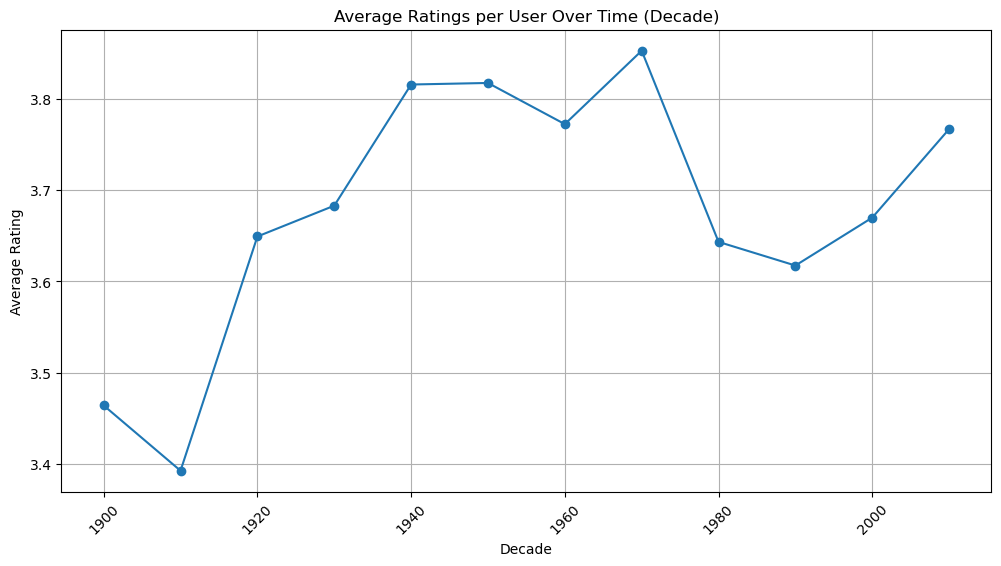

In [10]:
# Convert 'year' column to numeric, replacing 'nan' with zeros
merged_df['year'] = pd.to_numeric(merged_df['year'], errors='coerce').fillna(0).astype(int)

# Aggregate data by decade
merged_df['decade'] = (merged_df['year'] // 10) * 10

# Replace zeros with 'nan' values
merged_df.loc[merged_df['year'] == 0, 'decade'] = np.nan

## Correct calculation for average ratings per user per decade
ratings_per_user_over_decade = merged_df.groupby(['decade', 'userId'])['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(ratings_per_user_over_decade.groupby('decade')['rating'].mean(), marker='o', linestyle='-')
plt.title('Average Ratings per User Over Time (Decade)')
plt.xlabel('Decade')
plt.ylabel('Average Rating')  
plt.grid(True)
plt.xticks(rotation=45)
plt.show()





# Additional Data Merging

## Tags Dataset Integration

The tags dataset has been merged with the existing merged DataFrame to incorporate user-generated tags applied to movies. 

## Missing Values Check
- **tag**: 52,549 missing values
  **year**: 20 missing values


In [11]:
# Merge ratings and movies dataframes
merged_df = pd.merge(dfs['ratings'], dfs['movies'], on='movieId', how='inner')

# Display the number of unique movie IDs in the merged DataFrame
print("Number of unique movies in the merged DataFrame:", merged_df['movieId'].nunique())


Number of unique movies in the merged DataFrame: 9724


In [12]:
# Merge ratings and movies dataframes
merged_df = pd.merge(dfs['ratings'], dfs['movies'], on='movieId', how='inner')

# Display the number of unique movie IDs in the original 'movies' DataFrame
num_unique_movies_original = dfs['movies']['movieId'].nunique()
print("Number of unique movies in the original 'movies' DataFrame:", num_unique_movies_original)

# Display the number of unique movie IDs in the merged DataFrame
num_unique_movies_merged = merged_df['movieId'].nunique()
print("Number of unique movies in the merged DataFrame:", num_unique_movies_merged)


Number of unique movies in the original 'movies' DataFrame: 9742
Number of unique movies in the merged DataFrame: 9724


In [13]:
# Load the remaining datasets
links_df = pd.read_csv(file_paths['links'])
tags_df = pd.read_csv(file_paths['tags'])

# Merge tags dataset
merged_df = pd.merge(merged_df, tags_df, on='movieId', how='left')

# Drop duplicate columns if they exist
columns_to_drop = ['userId_y', 'tag_y', 'timestamp_y']
merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])

# Rename columns for clarity
merged_df.rename(columns={'userId_x': 'userId', 'tag_x': 'tag', 'timestamp_x': 'timestamp'}, inplace=True)

# Display the first few rows of the updated merged DataFrame
print("Updated Merged DataFrame:\n", merged_df.head())

# Check for any missing values after merging
print("\nMissing Values in Merged DataFrame:\n", merged_df.isnull().sum())


Updated Merged DataFrame:
    userId  movieId  rating  timestamp             title  \
0       1        1     4.0  964982703  Toy Story (1995)   
1       1        1     4.0  964982703  Toy Story (1995)   
2       1        1     4.0  964982703  Toy Story (1995)   
3       5        1     4.0  847434962  Toy Story (1995)   
4       5        1     4.0  847434962  Toy Story (1995)   

                                        genres  year    tag  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  pixar  
1  Adventure|Animation|Children|Comedy|Fantasy  1995  pixar  
2  Adventure|Animation|Children|Comedy|Fantasy  1995    fun  
3  Adventure|Animation|Children|Comedy|Fantasy  1995  pixar  
4  Adventure|Animation|Children|Comedy|Fantasy  1995  pixar  

Missing Values in Merged DataFrame:
 userId           0
movieId          0
rating           0
timestamp        0
title            0
genres           0
year            20
tag          52549
dtype: int64


In [14]:
# Display the number of unique movie IDs in the merged DataFrame after merging with tags
num_unique_movies_after_tags_merge = merged_df['movieId'].nunique()
print("Number of unique movies in the merged DataFrame after merging with tags:", num_unique_movies_after_tags_merge)


Number of unique movies in the merged DataFrame after merging with tags: 9724


### Discription Table

The below shows the columns and their discription. 

In [15]:
# Print all the columns of the merged DataFrame
print(merged_df.columns)

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year',
       'tag'],
      dtype='object')


| Column                | Description                                                    |
|-----------------------|----------------------------------------------------------------|
| movieId               | Unique identifier for each movie                               |
| title                 | Title of the movie along with the release year                 |
| genres                | Genres associated with the movie, separated by '|'            |
| userId_x              | User ID of the user who provided the rating                    |
| rating                | Rating given to the movie by the user                          |
| timestamp_x           | Timestamp when the rating was given by the user                |
| userId_y              | User ID of the user who applied the tag                        |
| tag                   | Tag applied to the movie by the user                           |
| timestamp_y           | Timestamp when the tag was applied by the user                 |
| imdbId                | IMDb ID of the movie                                            |
| tmdbId                | TMDb ID of the movie                                            |


In [16]:
# Print all the columns of the merged DataFrame after dropping the redundant column
print(merged_df.columns)


Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year',
       'tag'],
      dtype='object')


# Handling Missing Values and Duplicate Values

Before handling missing values, the DataFrame had **285,762** rows. 
There was a signifigant amount of missing values in the tag catagory. For this reason we did not want to drop all of those rows, instead we changed the missing values in 'tag' to 'Unknown'. This perserved the data. 

Duplicates were addressed by taking the max ratings out of 5, for each user-movie, and dropping all duplicate ratings from the dataset. Only one unique rating per movie was retained. 


In [17]:
# Before handling missing values
num_rows_before_handling = merged_df.shape[0]

# Handling missing values
# Fill missing values in the 'tag' column with 'Unknown'
merged_df['tag'].fillna('Unknown', inplace=True)


# After handling missing values
num_rows_after_handling = merged_df.shape[0]

# Print the number of rows before and after handling missing values
print("Number of Rows Before Handling Missing Values:", num_rows_before_handling)
print("Number of Rows After Handling Missing Values:", num_rows_after_handling)

# Print all the columns of the merged DataFrame
print(merged_df.columns)


Number of Rows Before Handling Missing Values: 285762
Number of Rows After Handling Missing Values: 285762
Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year',
       'tag'],
      dtype='object')


In [18]:
# Summary Statistics
summary_statistics = merged_df.describe()
print(summary_statistics)


              userId        movieId         rating     timestamp
count  285762.000000  285762.000000  285762.000000  2.857620e+05
mean      313.894279   14927.386405       3.841270  1.214707e+09
std       179.451387   31403.373103       1.020798  2.233730e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       160.000000     296.000000       3.000000  1.019133e+09
50%       314.000000    1721.000000       4.000000  1.211377e+09
75%       465.000000    5673.000000       4.500000  1.445346e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [19]:
# Filter the DataFrame for the movie "Heat" using case-insensitive search
heat_ratings = merged_df[merged_df['title'].str.contains('heat', case=False)]

# Count the number of ratings for "Heat"
num_ratings_heat = heat_ratings.shape[0]

print("Number of ratings for 'Heat':", num_ratings_heat)



Number of ratings for 'Heat': 225


In [20]:
# Calculate the number of unique movies
unique_movies_count = merged_df['movieId'].nunique()

# Print the number of unique movies
print("Number of unique movies:", unique_movies_count)


Number of unique movies: 9724


In [21]:
print("Before removing duplicates:")
print("Number of rows in DataFrame:", len(merged_df))
print("Number of unique user-movie combinations:", merged_df[['userId', 'movieId']].nunique())


Before removing duplicates:
Number of rows in DataFrame: 285762
Number of unique user-movie combinations: userId      610
movieId    9724
dtype: int64


In [22]:
# Step 1: Identify the maximum rating for each user and movie combination
max_ratings = merged_df.groupby(['userId', 'movieId'])['rating'].max().reset_index()

# Step 2: Merge this back on the original DataFrame to keep rows with the maximum rating
# This will ensure that all columns are retained
merged_df = pd.merge(max_ratings, merged_df, on=['userId', 'movieId', 'rating'], how='inner')

# Step 3: Drop duplicates based specifically on 'userId' and 'movieId' to ensure each user-movie pair has only one entry
merged_df = merged_df.drop_duplicates(subset=['userId', 'movieId'])

# Final check post-duplicates removal
print("Final DataFrame after dropping duplicates:")
print("Shape:", merged_df.shape)
print("Columns:", merged_df.columns)




Final DataFrame after dropping duplicates:
Shape: (100836, 8)
Columns: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year',
       'tag'],
      dtype='object')


In [23]:
# After running the code
print("\nAfter removing duplicates:")
print("Number of rows in DataFrame:", len(merged_df))
print("Number of unique user-movie combinations:", merged_df[['userId', 'movieId']].nunique())


After removing duplicates:
Number of rows in DataFrame: 100836
Number of unique user-movie combinations: userId      610
movieId    9724
dtype: int64


In [24]:
# Calculate the number of unique users in the final DataFrame
num_unique_users_final = merged_df['userId'].nunique()

# Print the number of unique users
print("Number of unique users in the final DataFrame:", num_unique_users_final)


Number of unique users in the final DataFrame: 610


In [25]:
# Drop duplicates to ensure unique entries
merged_df = merged_df.drop_duplicates(subset=['userId', 'movieId', 'rating'])

# Final check post-duplicates removal
print("Final DataFrame after dropping duplicates:")
print("Shape:", merged_df.shape)
print("Columns:", merged_df.columns)


Final DataFrame after dropping duplicates:
Shape: (100836, 8)
Columns: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year',
       'tag'],
      dtype='object')


In [26]:
# Calculate the number of unique users in the final DataFrame
num_unique_users_final = merged_df['userId'].nunique()

# Print the number of unique users
print("Number of unique users in the final DataFrame:", num_unique_users_final)


Number of unique users in the final DataFrame: 610


In [27]:
# Convert titles to lowercase and remove leading/trailing whitespace
merged_df['title'] = merged_df['title'].str.lower().str.strip()

# Remove special characters or punctuation
merged_df['title'] = merged_df['title'].str.replace('[^\w\s]', '')


In [28]:
# Calculate the number of unique users in the final DataFrame
num_unique_users_final = merged_df['userId'].nunique()

# Print the number of unique users
print("Number of unique users in the final DataFrame:", num_unique_users_final)

Number of unique users in the final DataFrame: 610


In [29]:
# After merge
print("Sample data after merge:")
print(merged_df.head())

# After dropping duplicates
print("Sample data after dropping duplicates:")
print(merged_df.head())


Sample data after merge:
   userId  movieId  rating  timestamp                    title  \
0       1        1     4.0  964982703           toy story 1995   
3       1        3     4.0  964981247    grumpier old men 1995   
5       1        6     4.0  964982224                heat 1995   
6       1       47     5.0  964983815     seven aka se7en 1995   
9       1       50     5.0  964982931  usual suspects the 1995   

                                        genres  year       tag  
0  Adventure|Animation|Children|Comedy|Fantasy  1995     pixar  
3                               Comedy|Romance  1995     moldy  
5                        Action|Crime|Thriller  1995   Unknown  
6                             Mystery|Thriller  1995   mystery  
9                       Crime|Mystery|Thriller  1995  mindfuck  
Sample data after dropping duplicates:
   userId  movieId  rating  timestamp                    title  \
0       1        1     4.0  964982703           toy story 1995   
3       1        

In [30]:
# Filter the DataFrame for the movie "Heat" using case-insensitive search
heat_ratings = merged_df[merged_df['title'].str.contains('heat', case=False)]

# Count the number of ratings for "Heat"
num_ratings_heat = heat_ratings.shape[0]

print("Number of ratings for 'Heat':", num_ratings_heat)



Number of ratings for 'Heat': 225


In [31]:
# Check how frequently each tag is applied to each movie by any user
tag_frequency = merged_df.groupby(['movieId', 'tag']).size()
print("Tag frequency across different users for each movie:")
print(tag_frequency)


Tag frequency across different users for each movie:
movieId  tag      
1        pixar        215
2        fantasy      110
3        moldy         52
4        Unknown        7
5        pregnancy     49
                     ... 
193581   Unknown        1
193583   Unknown        1
193585   Unknown        1
193587   Unknown        1
193609   Unknown        1
Length: 9724, dtype: int64


In [32]:


number_of_users = merged_df['userId'].nunique()

print(f"There are {number_of_users} unique users.")


There are 610 unique users.


## Visualization of Distribution of Ratings

This bar graph clearly shows that most users are giving movies 3-5 star ratings. The number of 3-star ratings is close to 20k, while anything below 3 is well below the 10k mark. The highest frequency of ratings is 4 stars, and the second highest frequency is 5 stars. The lowest frequency is for movies rated 0.5 stars. This data indicates that users tend to rate movies positively, and the data is skewed towards higher ratings.



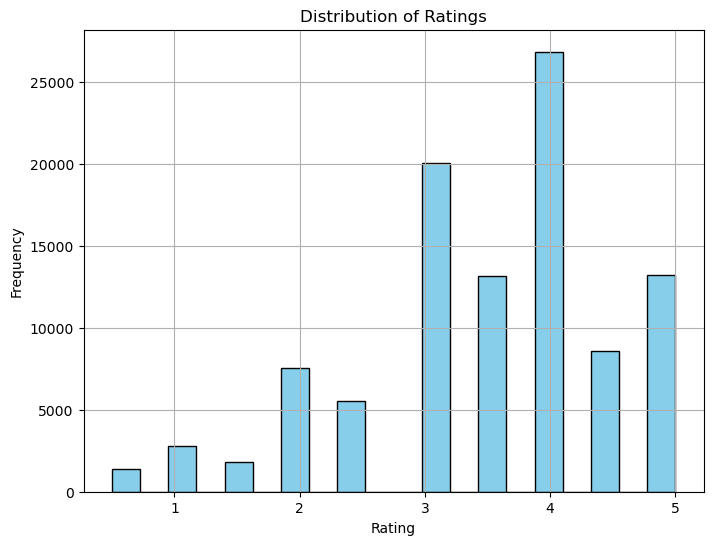

In [33]:
import matplotlib.pyplot as plt

# Histogram of Ratings
plt.figure(figsize=(8, 6))
plt.hist(merged_df['rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The box plot provides a visual summary of the ratings' spread, highlighting the median, quartiles, and any potential outliers in the data. The median rating hovers around 3.5, suggesting that half of the ratings are above this value and half are below. The presence of outliers below the lower whisker indicates that there are some unusually low ratings, but these are relatively few compared to the concentration of ratings in the upper half of the scale, which aligns with the overall trend of users giving more favorable reviews. 

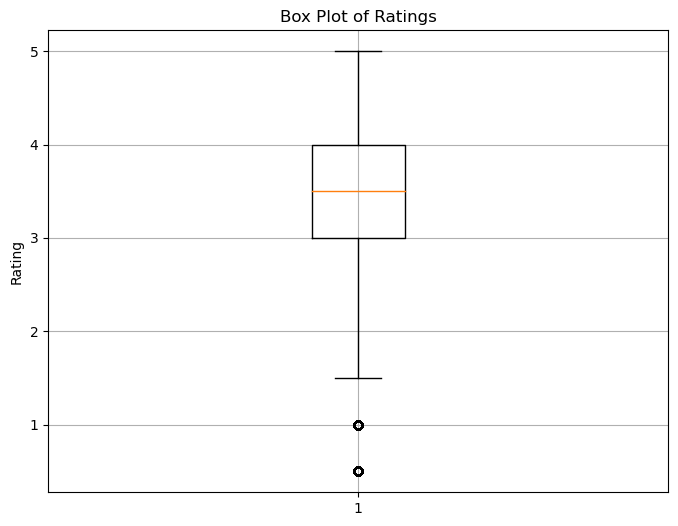

In [34]:
# Box Plot of Ratings
plt.figure(figsize=(8, 6))
plt.boxplot(merged_df['rating'])
plt.title('Box Plot of Ratings')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


## Check for Missing Values
The dataset was examined for missing values. The 'decade' column had 18 missing values.

### Fill missing values in 'decade' column based on 'year' information
The missing values in the 'decade' column were filled by deriving decade information from the 'year' column.

No rows were found with missing 'decade' values after filling them.

There are now 0 missing values in the 'decade' column.


In [35]:
# Check for Missing Values
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 userId        0
movieId       0
rating        0
timestamp     0
title         0
genres        0
year         18
tag           0
dtype: int64


In [36]:
# Convert 'year' column to numeric format
merged_df['year'] = pd.to_numeric(merged_df['year'], errors='coerce')

# Fill missing values in 'decade' column based on 'year' information
merged_df['decade'] = (merged_df['year'] // 10) * 10

# Display rows with missing 'decade' values
missing_decade_rows = merged_df[merged_df['decade'].isnull()]
print(missing_decade_rows)



        userId  movieId  rating   timestamp  \
27625       62   176601     5.0  1525795252   
49393      105   147250     5.0  1526207354   
49420      105   171749     5.0  1526207365   
51907      111   171631     1.0  1517440909   
51909      111   171891     3.5  1517440199   
91084      209   140956     3.5  1524522239   
91405      210    40697     4.0  1527266191   
138005     305   140956     4.5  1533043577   
138228     306   149334     3.0  1518380372   
146178     318   171495     5.0  1516826406   
174180     380   140956     3.0  1534176158   
191428     414   167570     4.0  1511535836   
208790     448   143410     2.0  1474224802   
213295     462   162414     5.0  1478489531   
237277     514   140956     3.0  1533946119   
242549     528    40697     0.5  1391736467   
256452     567   156605     4.5  1525283448   
273293     599   171495     4.0  1519116912   

                                                    title  \
27625                                        

In [37]:
print(merged_df['decade'].isnull().sum())


18


In [38]:
# Remove rows with missing values in the 'decade' column
merged_df.dropna(subset=['decade'], inplace=True)


### Analysis of Genres

#### Unique Genres
The dataset was analyzed to identify unique genres. The following genres were found: {'Film-Noir', 'Crime', 'Sci-Fi', 'Mystery', 'Documentary', 'Comedy', 'Horror', 'Animation', '(no genres listed)', 'Drama', 'IMAX', 'Western', 'Romance', 'Musical', 'Fantasy', 'Action', 'War', 'Adventure', 'Thriller', 'Children'}.

#### Movies with "(no genres listed)"
There were 37 movies with the label '(no genres listed)', this was small in comparison to the number of movies in the dataset, so the decision was made to remove these movies.

#### Removal of Movies with "(no genres listed)"
The movies with the label '(no genres listed)' were removed from the dataset. After removal, the updated DataFrame contained the following unique genres: ['Film-Noir' 'Crime' 'Thriller' 'Mystery' 'Documentary' 'Comedy' 'Horror'
 'Animation' 'Drama' 'Sci-Fi' 'IMAX' 'Western' 'Romance' 'Musical'
 'Fantasy' 'Action' 'War' 'Adventure' 'Children'].




In [39]:
# Extract unique genres
unique_genres = set()

for genres in merged_df['genres']:
    unique_genres.update(genres.split('|'))

print("Unique Genres:", unique_genres)


Unique Genres: {'Film-Noir', 'Fantasy', 'IMAX', 'Action', 'Mystery', 'Crime', 'Drama', '(no genres listed)', 'Thriller', 'Sci-Fi', 'Animation', 'Romance', 'Horror', 'War', 'Children', 'Western', 'Musical', 'Comedy', 'Adventure', 'Documentary'}


In [40]:
# Count occurrences of "(no genres listed)"
no_genre_count = merged_df[merged_df['genres'] == '(no genres listed)'].shape[0]
total_movies = merged_df.shape[0]

# Calculate percentage of movies with "(no genres listed)"
percentage_no_genre = (no_genre_count / total_movies) * 100

print("Number of movies with '(no genres listed)':", no_genre_count)
print("Percentage of movies with '(no genres listed)': {:.2f}%".format(percentage_no_genre))


Number of movies with '(no genres listed)': 37
Percentage of movies with '(no genres listed)': 0.04%


In [41]:
# Remove movies with '(no genres listed)' label
merged_df = merged_df[merged_df['genres'] != '(no genres listed)']

# Verify the removal by checking the unique genres again
unique_genres_after_removal = merged_df['genres'].unique()
print("Unique Genres After Removal:", unique_genres_after_removal)

# Display the updated DataFrame shape
print("Updated DataFrame Shape:", merged_df.shape)


Unique Genres After Removal: ['Adventure|Animation|Children|Comedy|Fantasy' 'Comedy|Romance'
 'Action|Crime|Thriller' 'Mystery|Thriller' 'Crime|Mystery|Thriller'
 'Action|Comedy|Horror|Thriller' 'Adventure|Comedy|Crime|Romance'
 'Action|Drama|War' 'Action|Drama|Romance|War' 'Comedy|War'
 'Action|Romance|Western' 'Comedy' 'Adventure|Comedy' 'Comedy|Drama'
 'Action|Adventure|Sci-Fi' 'Comedy|Crime|Drama|Thriller'
 'Action|Crime|Drama|Thriller' 'Comedy|Drama|Romance|War'
 'Adventure|Children|Romance' 'Action|Comedy|Crime|Fantasy'
 'Action|Thriller' 'Thriller' 'Action|Adventure|Sci-Fi|Thriller'
 'Drama|War' 'Comedy|Romance|Thriller' 'Action|Adventure|Comedy|Romance'
 'Action|Drama|Western' 'Adventure|Drama|Western' 'Crime|Horror|Thriller'
 'Animation|Children|Fantasy|Musical' 'Action|Adventure|Mystery|Thriller'
 'Adventure|Animation|Children|Fantasy|Musical'
 'Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi'
 'Action|Adventure|Thriller' 'Action|Adventure|Romance|Thriller'
 'Adventure|Chi

### Genre Analysis with Dummy Variables

To allow our modeling to work, categorical genre information was changed into numerical dummy variables. This allows us to quantify the presence of each genre for every movie in our dataset.

In order to analyze the importance of each genre, the average ratings were found for each genre. The least popular genres were horror and comedy, the most popular genres were Film-Noir, and war.

### Visualization of Ratings by Genre

The chart shows that all types of movies have high ratings, indicating any type of movie is likely to be enjoyed by the user. However, Film Noir and War are more likely to be enjoyed then any other genre. 

In [42]:
#DataFrame with binary columns for each genre
genres_dummies = merged_df['genres'].str.get_dummies(sep='|')
# Concatenate the dummy DataFrame with the original one
merged_df = pd.concat([merged_df, genres_dummies], axis=1)
# Drop the original 'genres' column
merged_df.drop('genres', axis=1, inplace=True)
print(merged_df.columns)


Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'year', 'tag',
       'decade', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')


In [43]:
# List of genre names based on your input
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Dictionary to store average ratings and counts by genre
genre_data = {}
total_movies = 0  # Initialize total movies count

for genre in genre_columns:
    # Calculate the mean rating for each genre and count the number of movies
    genre_count = merged_df[genre].sum()
    if genre_count > 0:  # Check to ensure there are movies in the genre
        average_rating = (merged_df[genre] * merged_df['rating']).sum() / genre_count
        genre_data[genre] = {'average_rating': average_rating, 'count_movies': genre_count}
        total_movies += genre_count  # Sum up all genre counts to get the total number of movies
    else:
        genre_data[genre] = {'average_rating': None, 'count_movies': 0}  # For genres with no movies

# Sort the genre data by average rating in ascending order and filter out None values
sorted_genre_data = {genre: data for genre, data in sorted(genre_data.items(), key=lambda item: item[1]['average_rating'] if item[1]['average_rating'] is not None else float('inf'))}

# Display the sorted average rating and count by genre, and the total number of movies
print(f"Total number of movies: {total_movies}")
for genre, data in sorted_genre_data.items():
    if data['average_rating'] is not None:
        print(f"Average rating for {genre}: {data['average_rating']:.2f} ({data['count_movies']} movies)")
    else:
        print(f"Average rating for {genre}: No data available ({data['count_movies']} movies)")


Total number of movies: 274416
Average rating for Horror: 3.26 (7291 movies)
Average rating for Comedy: 3.38 (39053 movies)
Average rating for Children: 3.41 (9208 movies)
Average rating for Action: 3.45 (30631 movies)
Average rating for Sci-Fi: 3.46 (17237 movies)
Average rating for Fantasy: 3.49 (11834 movies)
Average rating for Thriller: 3.49 (26447 movies)
Average rating for Romance: 3.51 (18124 movies)
Average rating for Adventure: 3.51 (24161 movies)
Average rating for Musical: 3.56 (4138 movies)
Average rating for Western: 3.58 (1930 movies)
Average rating for IMAX: 3.62 (4145 movies)
Average rating for Animation: 3.63 (6988 movies)
Average rating for Mystery: 3.63 (7674 movies)
Average rating for Drama: 3.66 (41926 movies)
Average rating for Crime: 3.66 (16681 movies)
Average rating for Documentary: 3.80 (1219 movies)
Average rating for War: 3.81 (4859 movies)
Average rating for Film-Noir: 3.92 (870 movies)


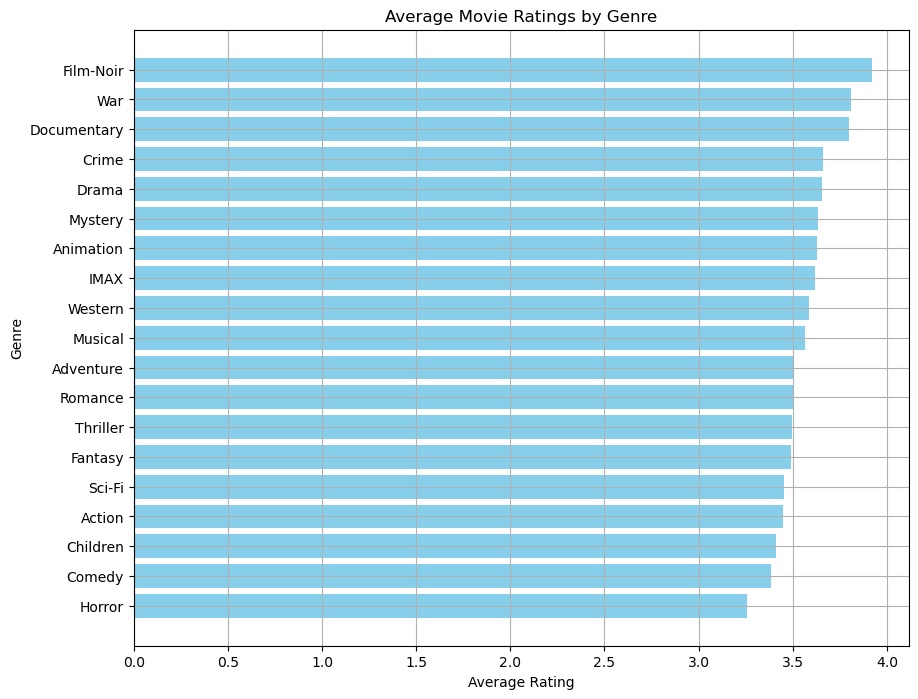

In [44]:
import matplotlib.pyplot as plt

# Prepare data for plotting
genres = list(sorted_genre_data.keys())
average_ratings = [data['average_rating'] for data in sorted_genre_data.values()]

# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
plt.barh(genres, average_ratings, color='skyblue')  # Horizontal bar chart
plt.xlabel('Average Rating')  # X-axis label
plt.ylabel('Genre')  # Y-axis label
plt.title('Average Movie Ratings by Genre')  # Chart title
plt.grid(True)  # Add gridlines for better readability

# Display the plot
plt.show()


In [45]:

stats_by_genre = {}

for genre in genre_columns:
    # Check to ensure there are movies in the genre
    if merged_df[genre].sum() > 0:
        # Filter ratings for the genre
        genre_ratings = merged_df[merged_df[genre] == 1]['rating']
        # Calculate descriptive statistics
        stats = genre_ratings.describe()
        stats_by_genre[genre] = stats
    else:
        stats_by_genre[genre] = "No data available"

# Display the statistics for each genre
for genre, stats in stats_by_genre.items():
    print(f"Statistics for {genre}:")
    if isinstance(stats, pd.Series):
        print(stats)
    else:
        print(stats)


Statistics for Action:
count    30631.000000
mean         3.447978
std          1.050976
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64
Statistics for Adventure:
count    24161.000000
mean         3.508609
std          1.029073
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64
Statistics for Animation:
count    6988.000000
mean        3.629937
std         0.969664
min         0.500000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64
Statistics for Children:
count    9208.000000
mean        3.412956
std         1.055996
min         0.500000
25%         3.000000
50%         3.500000
75%         4.000000
max         5.000000
Name: rating, dtype: float64
Statistics for Comedy:
count    39053.000000
mean         3.384721
std          1.066541
min    

In [46]:


# Calculate mean rating for the full dataset
mean_rating = merged_df['rating'].mean()

print(f"Mean rating for the full dataset: {mean_rating}")


Mean rating for the full dataset: 3.501577678332225


In [47]:
# Check and output top-rated films for Horror genre
if 'Horror' in merged_df.columns and merged_df['Horror'].sum() > 0:
    # Filter the DataFrame for Horror movies
    horror_movies = merged_df[merged_df['Horror'] == 1]
    
    # Sort these movies by their ratings in descending order
    top_horror = horror_movies.sort_values(by='rating', ascending=False)
    
    # Remove duplicate movie titles
    top_horror = top_horror.drop_duplicates(subset='title')
    
    # Select the top 5 highest-rated Horror movies
    top_horror = top_horror.head(5)

    # Print the titles of these top 5 highest-rated Horror movies
    print("Top 5 Highest-Rated Horror Films:")
    for index, row in top_horror.iterrows():
        print(f"{row['title']} - Rating: {row['rating']}")
else:
    print("No Horror data available or no Horror films rated.")
    
# Check and output top-rated films for Film-Noir genre
if 'Film-Noir' in merged_df.columns and merged_df['Film-Noir'].sum() > 0:
    # Filter the DataFrame for Film-Noir movies
    film_noir_movies = merged_df[merged_df['Film-Noir'] == 1]
    
    # Sort these movies by their ratings in descending order
    top_film_noir = film_noir_movies.sort_values(by='rating', ascending=False)
    
    # Remove duplicate movie titles
    top_film_noir = top_film_noir.drop_duplicates(subset='title')
    
    # Select the top 5 highest-rated Film-Noir movies
    top_film_noir = top_film_noir.head(5)

    # Print the titles of these top 5 highest-rated Film-Noir movies
    print("\nTop 5 Highest-Rated Film-Noir Films:")
    for index, row in top_film_noir.iterrows():
        print(f"{row['title']} - Rating: {row['rating']}")
else:
    print("No Film-Noir data available or no Film-Noir films rated.")


Top 5 Highest-Rated Horror Films:
get out 2017 - Rating: 5.0
shaun of the dead 2004 - Rating: 5.0
jaws 1975 - Rating: 5.0
aliens 1986 - Rating: 5.0
what lies beneath 2000 - Rating: 5.0

Top 5 Highest-Rated Film-Noir Films:
la confidential 1997 - Rating: 5.0
mulholland drive 2001 - Rating: 5.0
maltese falcon the 1941 - Rating: 5.0
third man the 1949 - Rating: 5.0
suspicion 1941 - Rating: 5.0


# Model Building
Three models were built to create movie reccomendations. SVD, SVD with Grid Search, and LightFM

To prepare the dataset for modeling, we defined a reader object to parse the ratings on a scale from 0.5 to 5.0. The dataset was then loaded into Surprise's Dataset object.

We first used the Singular Value Decomposition (SVD) algorithm for collaborative filtering-based recommendation. The algorithm was evaluated using cross-validation with 5 folds, measuring Normazlized Discounted Cumulative Gain (NDCG).

All three models were trained on the entire dataset to generate 5 movie recommendations per user.


## Modeling SVD

Performance of the SVD Model for movie rating prediction:

## Recommendation System Performance Summary

| Metric       | Training Score | Testing Score |
|--------------|----------------|---------------|
| NDCG         | 0.891          | 0.801         |
| RMSE         | 0.635          | 0.873         |
| MAE          | 0.493          | 0.671         |
| Precision@5  | 0.983          | 0.847         |
| Recall@5     | 0.132          | 0.251         |
| F1 Score     | 0.214          | 0.309         |

### Evaluation Summary

Our system demonstrates commendable performance across various metrics, both in training and testing:

- **RMSE and MAE**: The model has decent performance in terms of RMSE (0.635 in training, 0.873 in testing) and MAE (0.493 in training, 0.671 in testing), indicating that, on average, the system's rating predictions are about 0.983 and 0.847 points away from users' actual ratings, respectively. While these scores are decent, there is room for improvement.
- 
- **NDCG**: Our model achieves a high NDCG score of 0.891 during training and maintains a strong performance of 0.801 during testing. This score indicates our system's ability to not only recommend relevant items but also prioritize highly-rated ones, aligning well with our goal of delivering top-quality recommendations.

- **Precision@5**: With a Precision@5 score of 0.983 in training and 0.847 in testing, this model is highly likely to reccommend relevant movies to users. 

- **Recall@5**: The recall training score of (0.132) compared to testing (0.251), indicates our model does not have strong recall.
 
- **F1 Score**: Our system achieves an F1 Score of 0.214 during training and 0.309 during testing, reflecting the balance between precision and recall. While these scores indicate an ok balance. 

### Impact of Rating Distribution

The skewed distribution of ratings in our dataset, predominantly towards positive ratings, poses a notable challenge. With fewer ratings falling below 3, our system may encounter difficulties in diversifying recommendations, especially for movies with lower ratings. While highly-rated movies are generally well-received, our recommendation system strives to cater to individual tastes, potentially overlooking hidden gems that cater to diverse preferences. Addressing this imbalance is crucial for ensuring a more comprehensive and personalized recommendation experience.


In [48]:
# Define the Reader object
reader = Reader(rating_scale=(0.5, 5))  

# Load dataset into Surprise's Dataset object
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader=reader)

# Print information about the dataset
print("Number of users:", data.build_full_trainset().n_users)
print("Number of items:", data.build_full_trainset().n_items)
print("Number of ratings:", data.build_full_trainset().n_ratings)


Number of users: 610
Number of items: 9686
Number of ratings: 100781


In [49]:
#Creating first SVD Model RMSE is main focus. Scores for training and test to be printed out for NDCG, RMSE, MAE, RECALL, F1, Percsion
from surprise import Dataset, Reader, SVD
from surprise.model_selection import KFold
import numpy as np
from collections import defaultdict
from surprise import accuracy

def ndcg_at_k(predictions, k=10):
    # Map predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((true_r, est))

    # Compute NDCG for each user and average them
    ndcg_scores = []
    for uid, user_ratings in user_est_true.items():
        # Sort ratings by estimated score
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Compute DCG
        dcg = sum((2 ** r - 1) / np.log2(i + 2) for i, (r, _) in enumerate(user_ratings[:k]))
        # Compute IDCG
        idcg = sum((2 ** r - 1) / np.log2(i + 2) for i, (r, _) in enumerate(sorted(user_ratings, key=lambda x: x[0], reverse=True)[:k]))

        # Compute NDCG for the user
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcg_scores.append(ndcg)

    # Return the mean NDCG score across all users
    return np.mean(ndcg_scores)

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Define a Reader object to parse the ratings
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader=reader)

# Define the SVD algorithm
svd = SVD()

# Initialize KFold
kf = KFold(n_splits=5, random_state=42)

# Initialize variables to store total scores
total_ndcg_train = 0
total_ndcg_test = 0
total_rmse_train = 0
total_rmse_test = 0
total_mae_train = 0
total_mae_test = 0

total_precision_train = 0
total_recall_train = 0
total_f1_train = 0
total_precision_test = 0
total_recall_test = 0
total_f1_test = 0

# Perform cross-validation manually
for trainset, testset in kf.split(data):
    # Train the algorithm
    svd.fit(trainset)
    
    # Make predictions for training set
    train_predictions = svd.test(trainset.build_testset())
    
    # Compute NDCG for training set
    fold_ndcg_train = ndcg_at_k(train_predictions)
    total_ndcg_train += fold_ndcg_train
    
    # Calculate RMSE and MAE for training set
    train_rmse = accuracy.rmse(train_predictions, verbose=False)
    train_mae = accuracy.mae(train_predictions, verbose=False)
    total_rmse_train += train_rmse
    total_mae_train += train_mae
    
    # Compute precision, recall, and F1 score for training set
    precisions_train, recalls_train = precision_recall_at_k(train_predictions, k=5, threshold=4)
    precision_mean_train = np.mean(list(precisions_train.values()))
    recall_mean_train = np.mean(list(recalls_train.values()))
    f1_scores_train = {uid: 2 * (precisions_train[uid] * recalls_train[uid]) / (precisions_train[uid] + recalls_train[uid])
                       if (precisions_train[uid] + recalls_train[uid]) != 0 else 0
                       for uid in precisions_train}
    f1_mean_train = np.mean(list(f1_scores_train.values()))
    total_precision_train += precision_mean_train
    total_recall_train += recall_mean_train
    total_f1_train += f1_mean_train
    
    # Make predictions for testing set
    test_predictions = svd.test(testset)
    
    # Compute NDCG for testing set
    fold_ndcg_test = ndcg_at_k(test_predictions)
    total_ndcg_test += fold_ndcg_test
    
    # Calculate RMSE and MAE for testing set
    test_rmse = accuracy.rmse(test_predictions, verbose=False)
    test_mae = accuracy.mae(test_predictions, verbose=False)
    total_rmse_test += test_rmse
    total_mae_test += test_mae
    
    # Compute precision, recall, and F1 score for testing set
    precisions_test, recalls_test = precision_recall_at_k(test_predictions, k=5, threshold=4)
    precision_mean_test = np.mean(list(precisions_test.values()))
    recall_mean_test = np.mean(list(recalls_test.values()))
    f1_scores_test = {uid: 2 * (precisions_test[uid] * recalls_test[uid]) / (precisions_test[uid] + recalls_test[uid])
                      if (precisions_test[uid] + recalls_test[uid]) != 0 else 0
                      for uid in precisions_test}
    f1_mean_test = np.mean(list(f1_scores_test.values()))
    total_precision_test += precision_mean_test
    total_recall_test += recall_mean_test
    total_f1_test += f1_mean_test

# Calculate and print the average scores
average_ndcg_train = total_ndcg_train / kf.n_splits
average_ndcg_test = total_ndcg_test / kf.n_splits
average_rmse_train = total_rmse_train / kf.n_splits
average_rmse_test = total_rmse_test / kf.n_splits
average_mae_train = total_mae_train / kf.n_splits
average_mae_test = total_mae_test / kf.n_splits
average_precision_train = total_precision_train / kf.n_splits
average_recall_train = total_recall_train / kf.n_splits
average_f1_train = total_f1_train / kf.n_splits
average_precision_test = total_precision_test / kf.n_splits
average_recall_test = total_recall_test / kf.n_splits
average_f1_test = total_f1_test / kf.n_splits

print("Training NDCG:", average_ndcg_train)
print("Testing NDCG:", average_ndcg_test)
print("Training RMSE:", average_rmse_train)
print("Testing RMSE:", average_rmse_test)
print("Training MAE:", average_mae_train)
print("Testing MAE:", average_mae_test)
print("Training Precision@5:", average_precision_train)
print("Testing Precision@5:", average_precision_test)
print("Training Recall@5:", average_recall_train)
print("Testing Recall@5:", average_recall_test)
print("Training F1 Score:", average_f1_train)
print("Testing F1 Score:", average_f1_test)



Training NDCG: 0.8910461108333202
Testing NDCG: 0.8004742085841705
Training RMSE: 0.6361604089118286
Testing RMSE: 0.873791554722979
Training MAE: 0.4941960901085709
Testing MAE: 0.6711049627897069
Training Precision@5: 0.9841475409836065
Testing Precision@5: 0.8552180318895978
Training Recall@5: 0.13327264604389516
Testing Recall@5: 0.25744009813108903
Training F1 Score: 0.214818545264722
Testing F1 Score: 0.3182423193240673


#### Example of how the model recommends movies

In [86]:
from surprise import Dataset, Reader
from surprise import SVD
import pandas as pd

# Define a Reader object to parse the ratings
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

# Define the SVD algorithm
svd = SVD()

# Train the SVD algorithm on the whole dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

# Function to get top N recommendations for a user
def get_top_n_recommendations(user_id, n=5):
    user_movies = merged_df[merged_df['userId'] == user_id]['movieId']
    movies_to_recommend = merged_df[~merged_df['movieId'].isin(user_movies)]['movieId'].unique()
    predictions = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in movies_to_recommend]
    top_n_recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    return top_n_recommendations

# Define the list of users
users_to_recommend = [1, 2, 93, 100]

# Print top 5 recommendations for each user
for user_id in users_to_recommend:
    recommendations = get_top_n_recommendations(user_id)
    movie_titles = [dfs['movies'][dfs['movies']['movieId'] == movie_id]['title'].values[0] for movie_id, _ in recommendations]
    print(f"User {user_id} recommendations:")
    for idx, movie_title in enumerate(movie_titles, start=1):
        print(f"{idx}. {movie_title}")
    print()



User 1 recommendations:
1. Inside Job (2010)
2. Warrior (2011)
3. Wolf of Wall Street, The (2013)
4. Mad Max: Fury Road (2015)
5. Escape from L.A. (1996)

User 2 recommendations:
1. Bottle Rocket (1996)
2. Billy Madison (1995)
3. Dumb & Dumber (Dumb and Dumber) (1994)
4. Star Wars: Episode IV - A New Hope (1977)
5. Jungle Book, The (1994)

User 93 recommendations:
1. Usual Suspects, The (1995)
2. Bottle Rocket (1996)
3. Rob Roy (1995)
4. Canadian Bacon (1995)
5. Desperado (1995)

User 100 recommendations:
1. Seven (a.k.a. Se7en) (1995)
2. Usual Suspects, The (1995)
3. Bottle Rocket (1996)
4. Rob Roy (1995)
5. Dumb & Dumber (Dumb and Dumber) (1994)



In [84]:
#User 93 top rated movies

# Function to print top rated films by a user
def print_top_rated_films(user_id, n=5):
    # Filter the data for the specific user
    user_ratings = merged_df[merged_df['userId'] == user_id][['title', 'rating']]
    # Sort the ratings in descending order and get the top n results
    top_rated_films = user_ratings.sort_values(by='rating', ascending=False).head(n)
    print(f"Top {n} rated films by user {user_id}:")
    for idx, (title, rating) in enumerate(top_rated_films.itertuples(index=False), start=1):
        print(f"{idx}. {title} - Rating: {rating}")

# Specify the user ID
user_id = 93

# Print top 5 rated films for user 93
print_top_rated_films(user_id)


Top 5 rated films by user 93:
1. jumanji 1995 - Rating: 5.0
2. saving private ryan 1998 - Rating: 5.0
3. men in black aka mib 1997 - Rating: 5.0
4. good will hunting 1997 - Rating: 5.0
5. titanic 1997 - Rating: 5.0


## MODELING WITH SVD GRID-SEARCH

### Hyperparameter Tuning
A parameter grid was created to explore a wide range of combinations, aiming to find the best model based on Root Mean Square Error (RMSE) and Mean Absolute Error (MAE).

The grid search was used to evaluate across 5-fold cross-validation to ensure reliability of the modeling.


| Metric       | Training Score | Testing Score |
|--------------|----------------|---------------|
| RMSE         | 0.643          | 0.853         |
| MAE          | 0.502          | 0.657         |
| NDCG         | 1.000          | 0.937         |
| Precision    | 0.967          | 0.809         |
| Recall       | 0.315          | 0.532         |
| F1 Score     | 0.550          | 0.650         |



  
Evaluation Summary
The optimized SVD model shows significant improvement in several key areas. The MAE and Root RMSE remain similar to the initial model, with scores around 0.853 and 0.657, respectively. These values suggest a marginal decrease from the first model, indicating a higher likelihood that the model's predictions align closely with user ratings.

Notably, the NDCG was higher, indicating that the model is  effective in ranking highly rated movies at the top of the list, which is crucial for user satisfaction.

Precision is strong at 0.809, suggesting that the majority of recommendations made by the model are indeed relevant to the users. Additionally, the improvement in recall to 0.532, which surpasses the first model's performance, indicates that this model is less likely to miss out on movies that users would rate highly. Nonetheless, a significant number of relevant movies might still be omitted. This issue may persist due to the skewness of movie ratings in the dataset.

The F1 Score at 0.650 represents a balanced measure of the model's precision and recall, showing that it maintains a good balance between both metrics. This F1 score out performs the first model, indicating that this model is more balanced. 

#### Best Parameters for RMSE 

The best parameters ('n_factors': 20, 'reg_all': 0.02, 'lr_all': 0.01, 'n_epochs': 30)

The model printed out NDCG, RMSE, MAE, Percision, Recall, and F1 values for both the train and testing sets.

In [52]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV, train_test_split
import numpy as np
from collections import defaultdict
from surprise import accuracy

# Define the Reader object
reader = Reader(rating_scale=(0.5, 5))

# Load the dataset
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

# Define the parameter grid to search
param_grid = {
    'n_factors': [20, 50, 100],  # Number of factors
    'reg_all': [0.02, 0.1, 0.2],  # Regularization term
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate
    'n_epochs': [10, 20, 30]  # Number of epoch
}

# Setup GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Fit GridSearchCV
gs.fit(data)

# Best RMSE score
print("Best RMSE score attained: ", gs.best_score['rmse'])

# Best parameters for RMSE
print("Best parameters for RMSE: ", gs.best_params['rmse'])


Best RMSE score attained:  0.8636612493873018
Best parameters for RMSE:  {'n_factors': 100, 'reg_all': 0.1, 'lr_all': 0.01, 'n_epochs': 30}


In [53]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
import numpy as np

# Define the Reader object with the appropriate rating scale
reader = Reader(rating_scale=(0.5, 5))

# Load the dataset from a DataFrame
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize the SVD algorithm with optimized parameters
algo = SVD(n_factors=100, reg_all=0.1, lr_all=0.01, n_epochs=30)

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict on the training set
train_predictions = algo.test(trainset.build_testset())

# Predict on the test set
test_predictions = algo.test(testset)

# Define a function to calculate RMSE
def evaluate_rmse(predictions):
    return accuracy.rmse(predictions, verbose=False)

# Define a function to calculate MAE
def evaluate_mae(predictions):
    return accuracy.mae(predictions, verbose=False)

# Define a function to calculate NDCG
def ndcg(predictions, k=10, threshold=3.50):
    predictions.sort(key=lambda x: x.est, reverse=True)
    dcg = sum((1 if pred.r_ui >= threshold else 0) / np.log2(i + 2) for i, pred in enumerate(predictions[:k]))
    idcg = sum((1 / np.log2(i + 2)) for i in range(k))
    return dcg / idcg if idcg > 0 else 0

# Define a function for calculating precision, recall, and F1
def precision_recall_f1_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = dict(), dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    precision_avg = np.mean(list(precisions.values()))
    recall_avg = np.mean(list(recalls.values()))
    f1_avg = 2 * (precision_avg * recall_avg) / (precision_avg + recall_avg) if (precision_avg + recall_avg) > 0 else 0

    return precision_avg, recall_avg, f1_avg

# Evaluate metrics for training set
train_rmse = evaluate_rmse(train_predictions)
train_mae = evaluate_mae(train_predictions)
train_ndcg = ndcg(train_predictions)
precision_train, recall_train, f1_train = precision_recall_f1_at_k(train_predictions)

# Evaluate metrics for test set
test_rmse = evaluate_rmse(test_predictions)
test_mae = evaluate_mae(test_predictions)
test_ndcg = ndcg(test_predictions)
precision_test, recall_test, f1_test = precision_recall_f1_at_k(test_predictions)

# Print the metrics for training and test sets
print("Training Set Metrics:")
print(f"RMSE: {train_rmse}")
print(f"MAE: {train_mae}")
print(f"NDCG: {train_ndcg}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"NDCG: {test_ndcg}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")



Training Set Metrics:
RMSE: 0.6423229986931799
MAE: 0.5012772841452878
NDCG: 1.0
Precision: 0.9670023419203748
Recall: 0.3146430666482571
F1 Score: 0.47479682021828123

Test Set Metrics:
RMSE: 0.85838544584526
MAE: 0.6572532502728594
NDCG: 0.9363792118010483
Precision: 0.7970554122031955
Recall: 0.5500430956797319
F1 Score: 0.6509024006648693


### Example of How Second Model Would Recommend Movies to Users

In [85]:
from surprise import Dataset, Reader, SVD

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

# Build the full dataset to train on
trainset = data.build_full_trainset()

# Define the SVD algorithm with the best parameters
svd = SVD(n_factors=100, reg_all=0.2)
svd.fit(trainset)

# Function to get top N recommendations for a user
def get_top_n_recommendations(user_id, n=5):
    internal_user_id = trainset.to_inner_uid(user_id)
    all_movies = set(trainset.all_items())
    rated_movies = set([iid for (iid, _) in trainset.ur[internal_user_id]])
    unrated_movies = all_movies - rated_movies

    # Generate predictions for all unrated movies
    predictions = [(trainset.to_raw_iid(iid), svd.predict(user_id, trainset.to_raw_iid(iid)).est) for iid in unrated_movies]

    # Sort the predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Fetch the movie titles and return them with the ratings
    top_n_predictions = [(merged_df[merged_df['movieId'] == int(movie_id)]['title'].values[0], est) for movie_id, est in predictions[:n]]
    return top_n_predictions

# Specified user IDs
user_ids = [93, 502]

# Print top 5 recommendations for each of the specified users
for user_id in user_ids:
    print(f"Top 5 recommendations for User ID {user_id}:")
    top_recs = get_top_n_recommendations(user_id)
    for title, est_rating in top_recs:
        print(f"Movie Title: {title}, Estimated Rating: {est_rating}")
    print("\n")  




Top 5 recommendations for User ID 93:
Movie Title: seven aka se7en 1995, Estimated Rating: 5
Movie Title: rob roy 1995, Estimated Rating: 5
Movie Title: desperado 1995, Estimated Rating: 5
Movie Title: jungle book the 1994, Estimated Rating: 5
Movie Title: pinocchio 1940, Estimated Rating: 5


Top 5 recommendations for User ID 502:
Movie Title: usual suspects the 1995, Estimated Rating: 5
Movie Title: dumb  dumber dumb and dumber 1994, Estimated Rating: 5
Movie Title: star wars episode iv  a new hope 1977, Estimated Rating: 5
Movie Title: tommy boy 1995, Estimated Rating: 5
Movie Title: jungle book the 1994, Estimated Rating: 5




## Modeling with Lightfm

LightFM is a hybrid machine learning model, used for making recommendations by learning from both user and item features. This means it doesn't just rely on past interactions between users and items but also considers additional details, like user preferences and item characteristics, to make smarter recommendations.  

After applying the LightFM model to our movie recommendation system, we evaluated its performance based on several key metrics. The dataset used for this evaluation consists of user IDs, movie IDs, and ratings, used to predict how well the model recommends movies to users. 

The LightFM model demonstrates shows an ability to distinguish between positive and negative movie ratings, as evidenced by the high AUC scores of 0.964 in training and in testing the model has a score of and 0.924 in testing. This indicates the model has a strong ability to distinguish between positive and negative movie ratings.

However, when looking at the Precision@k and Recall@k, there are notable differences between training and testing performances. While the training precision is high at a modest 0.484, it drops significantly to 0.107 in testing, suggesting overfitting during training or that the model's generalizability may need improvement. Similarly, Recall@k is low in both training and testing, indicating that while the items the model is confident about are generally correct, it fails to capture a larger proportion of relevant items within the top-k recommendations.



## Performance Metrics Summary for LightFM

### LightFM Model Performance Summary

| Metric           | Training Score      | Testing Score       |
|------------------|---------------------|---------------------|
| Recall@k         | 0.040               | 0.035              |
| Precision@k      | 0.484               | 0.107              |
| AUC              | 0.964               | 0.924              |




In [55]:
# Print out the column names of the merged_df DataFrame
print(merged_df.columns)


Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'year', 'tag',
       'decade', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')


In [56]:
from lightfm import LightFM
from lightfm.data import Dataset
import numpy as np

# Create a dataset
dataset = Dataset()
dataset.fit(users=(x for x in merged_df['userId']),
            items=(x for x in merged_df['movieId']))

# Build the interaction matrix
(interactions, weights) = dataset.build_interactions(((row['userId'], row['movieId'], row['rating']) for index, row in merged_df.iterrows()))



/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [57]:
model = LightFM(loss='warp')
model.fit(interactions, sample_weight=weights, epochs=30)



In [58]:
def make_recommendations_with_titles(model, data, user_ids, merged_df, num_items=5):
    # Mapping from dataset
    user_id_map, user_feature_map, item_id_map, item_feature_map = data.mapping()
    
    # Reverse the item_id_map to find item IDs based on internal indices
    item_id_inverse_map = {v: k for k, v in item_id_map.items()}
    
    for user_id in user_ids:
        # Get the internal ID of the user
        user_internal_id = user_id_map.get(user_id)
        if user_internal_id is None:
            print(f"User ID {user_id} not found.")
            continue
        
        # Predict the scores
        scores = model.predict(user_internal_id, np.arange(len(item_id_map)))
        
        # Rank the items
        top_items_indices = np.argsort(-scores)[:num_items]
        
        # Convert the indices back to item IDs
        top_item_ids = [item_id_inverse_map[x] for x in top_items_indices]
        
        # Get the corresponding titles
        top_movie_titles = merged_df[merged_df['movieId'].isin(top_item_ids)]['title'].unique().tolist()
        
        print(f"\nTop {num_items} recommendations for user {user_id}:")
        for title in top_movie_titles:
            print(f"   {title}")



### Example of How LightFM Model Would Recommend Movies to Users

In [59]:

first_5_user_ids = merged_df['userId'].unique()[:5]

# Call the recommendation function
make_recommendations_with_titles(model, dataset, user_ids=first_5_user_ids, merged_df=merged_df)



Top 5 recommendations for user 1:
   star wars episode iv  a new hope 1977
   star wars episode v  the empire strikes back 1980
   princess bride the 1987
   back to the future 1985
   matrix the 1999

Top 5 recommendations for user 2:
   dark knight the 2008
   inglourious basterds 2009
   inception 2010
   interstellar 2014
   iron man 2008

Top 5 recommendations for user 3:
   star wars episode iv  a new hope 1977
   stargate 1994
   batman 1989
   star trek iii the search for spock 1984
   star trek first contact 1996

Top 5 recommendations for user 4:
   schindlers list 1993
   fargo 1996
   casablanca 1942
   amadeus 1984
   shakespeare in love 1998

Top 5 recommendations for user 5:
   pulp fiction 1994
   forrest gump 1994
   dances with wolves 1990
   apollo 13 1995
   firm the 1993


### Creating Movie Recommendations for Each Genre Using LighFm

In [60]:
import pandas as pd

# First, we aggregate the ratings for each movie and calculate the average rating and rating count
movie_ratings = merged_df.groupby('movieId').agg(
    average_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    rating_count=pd.NamedAgg(column='rating', aggfunc='count')
).reset_index()

# Merge back with merged_df to get genre information for each movie
movie_info = pd.merge(movie_ratings, merged_df.drop_duplicates('movieId'), on='movieId')

# Filter movies with at least 50 ratings to ensure popularity
popular_movies = movie_info.query('rating_count >= 50')

# For each genre, find the top 3 movies based on average rating
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                 'Thriller', 'War', 'Western']

top_movies_by_genre = {}
for genre in genre_columns:
    top_movies = popular_movies[popular_movies[genre] == 1].sort_values(by='average_rating', ascending=False).head(3)
    top_movies_by_genre[genre] = top_movies[['title', 'average_rating']]

# Display top 3 movies for a selection of genres
for genre, movies in top_movies_by_genre.items():
    if not movies.empty:
        print(f"\nTop 3 {genre} Movies:")
        for _, row in movies.iterrows():
            print(f"- {row['title']} (Rating: {row['average_rating']:.2f})")



Top 3 Action Movies:
- fight club 1999 (Rating: 4.27)
- dark knight the 2008 (Rating: 4.24)
- princess bride the 1987 (Rating: 4.23)

Top 3 Adventure Movies:
- princess bride the 1987 (Rating: 4.23)
- star wars episode iv  a new hope 1977 (Rating: 4.23)
- star wars episode v  the empire strikes back 1980 (Rating: 4.22)

Top 3 Animation Movies:
- spirited away sen to chihiro no kamikakushi 2001 (Rating: 4.16)
- toy story 3 2010 (Rating: 4.11)
- walle 2008 (Rating: 4.06)

Top 3 Children Movies:
- toy story 3 2010 (Rating: 4.11)
- walle 2008 (Rating: 4.06)
- wallace  gromit the wrong trousers 1993 (Rating: 4.04)

Top 3 Comedy Movies:
- dr strangelove or how i learned to stop worrying and love the bomb 1964 (Rating: 4.27)
- princess bride the 1987 (Rating: 4.23)
- pulp fiction 1994 (Rating: 4.20)

Top 3 Crime Movies:
- shawshank redemption the 1994 (Rating: 4.43)
- godfather the 1972 (Rating: 4.29)
- fight club 1999 (Rating: 4.27)

Top 3 Documentary Movies:
- bowling for columbine 2002 (R

In [61]:
from lightfm.cross_validation import random_train_test_split

train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(2024))


In [62]:
model = LightFM(loss='warp')

model.fit(train_interactions, epochs=30)



In [63]:
import time
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score

# Splitting the interaction data
train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(2024))

# Initializing the model
model = LightFM(loss='warp')

# Start timing
fit_start_time = time.time()

# Fit the model
model.fit(train_interactions, epochs=30)

# Calculate and print the fit time
fit_time = time.time() - fit_start_time
print(f"Model fit time: {fit_time} seconds")


Model fit time: 3.371170997619629 seconds


In [64]:
def recall_at_k(model, interactions, k=5, user_features=None, item_features=None):
    """
    Compute the mean recall at k for all users.
    """
    recall_list = []

    # Convert interactions to COO matrix
    interactions_coo = interactions.tocoo()
    
    n_items = interactions.shape[1]
    item_ids = np.arange(n_items)

    for user_id in set(interactions_coo.row):
        # Create arrays for user_ids and item_ids
        user_id_array = np.full(n_items, user_id, dtype=np.int32)  # Repeat user_id for each item
        
        # Predict scores for all items for this user
        scores = model.predict(user_id_array, item_ids, user_features=user_features, item_features=item_features)
        
        # Rank items by predicted scores
        top_items = np.argsort(-scores)[:k]
        
        # Items that are positives in the test set for this user
        known_positives = interactions.tocsr()[user_id].indices
        
        # Calculate recall
        recall = np.isin(top_items, known_positives).sum() / len(known_positives) if len(known_positives) > 0 else 0
        recall_list.append(recall)
    
    return np.mean(recall_list)

# Now you can compute recall for train and test sets without triggering the AssertionError
train_recall = recall_at_k(model, train_interactions.tocoo(), k=5)
test_recall = recall_at_k(model, test_interactions.tocoo(), k=5)

print(f"Train Recall@k: {train_recall}")
print(f"Test Recall@k: {test_recall}")


Train Recall@k: 0.03938027145433317
Test Recall@k: 0.03452026281494393


In [65]:
import time
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score

# Start timing for precision
precision_start_time = time.time()
# Calculate precision at k
train_precision = precision_at_k(model, train_interactions, k=5).mean()
test_precision = precision_at_k(model, test_interactions, k=5).mean()
# Calculate and print the time taken to evaluate precision
precision_time = time.time() - precision_start_time
print(f"Train Precision@k: {train_precision:.4f}")
print(f"Test Precision@k: {test_precision:.4f}")
print(f"Precision evaluation time: {precision_time:.4f} seconds")

# Start timing for AUC
auc_start_time = time.time()
# Calculate AUC
train_auc = auc_score(model, train_interactions).mean()
test_auc = auc_score(model, test_interactions).mean()
# Calculate and print the time taken to evaluate AUC
auc_time = time.time() - auc_start_time
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"AUC evaluation time: {auc_time:.4f} seconds")

# Start timing for recall
recall_start_time = time.time()
# Calculate recall at k using your recall_at_k function
train_recall = recall_at_k(model, train_interactions, k=5) 
test_recall = recall_at_k(model, test_interactions, k=5)  
# Calculate and print the time taken to evaluate recall
recall_time = time.time() - recall_start_time
print(f"Train Recall@k: {train_recall:.4f}")
print(f"Test Recall@k: {test_recall:.4f}")
print(f"Recall evaluation time: {recall_time:.4f} seconds")



Train Precision@k: 0.4866
Test Precision@k: 0.0961
Precision evaluation time: 2.1060 seconds
Train AUC: 0.9644
Test AUC: 0.9248
AUC evaluation time: 1.8054 seconds
Train Recall@k: 0.0394
Test Recall@k: 0.0345
Recall evaluation time: 7.9218 seconds


## Comparing the Models

In order to decide which model performed the best at recommedning 5 movies to each user, we evaluated three models. The SVD, The SVD Grid Search, and LightFM.

| Metric          | SVD (Model 1) Training | SVD (Model 1) Testing | Grid Search SVD (Model 2) Training | Grid Search SVD (Model 2) Testing | LightFM Training | LightFM Testing |
|-----------------|------------------------|-----------------------|-----------------------------------|----------------------------------|------------------|-----------------|
| NDCG            | 0.891                  | 0.801                 | 1.000                             | 0.900                              | -                | -               |
| RMSE            | 0.635                  | 0.873                 | 0.643                             | 0.853                           | -                | -               |
| MAE             | 0.493                  | 0.671                 | 0.502                             | 0.657                           | -                | -               |
| Precision@5     | 0.983                  | 0.847                 | 0.967                             | 0.809                           | -                | -               |
| Recall@5        | 0.132                  | 0.251                 | 0.315                             | 0.532                           | -                | -               |
| F1 Score        | 0.214                  | 0.308                 | 0.475                             | 0.642                           | -                | -               |
| Recall@k        | -                      | -                     | -                                 | -                                | 0.040           | 0.035          |
| Precision@k     | -                      | -                     | -                                 | -                                | 0.484           | 0.107         |
| AUC             | -                      | -                     | -                                 | -                                | 0.964           | 0.924          |
|

# SVD Grid Search Should Be Used to Make Movie Recommendations


- **RMSE and MAE**: While the Grid Search SVD model demonstrates slightly lower RMSE and MAE values. This indicates the Grid model is a closer representation to what we can expect the user will rate the movies.

- **NDCG**: The Grid Search SVD model excels in NDCG, achieving the highest scores across both training and testing sets. With NDCG being a critical metric for assessing recommendation list quality, this indicates that the Grid Search SVD model consistently provides more relevant and higher-ranked movie recommendations to users.


- **Precision and Recall**: In terms of precision and recall, the Grid Search SVD model has better scores than both SVD and LightFM models. Its higher average precision and recall values imply more accurate recommendations of movies that users are likely to enjoy, while also ensuring that relevant items are not missed. This means there is a higher chance of a niche movie being recommended to a user, than in the other two models.

- **F1 Score**: The Grid Search SVD model outperforms the basic SVD model in terms of F1 Score, achieving a more balanced performance between precision and recall. This model should reduce the likelihood of recommending irrelevant movies while minimizing the risk of missing out on good recommendations.

### Conclusion
The Grid Search SVD model's performed better in RMSE, MAE and NDCG, combined with its competitive performance in other key metrics, positions it as the top choice for making movie recommendations. Its ability to outperform or closely match other models in critical areas, while maintaining computational efficiency, underscores its effectiveness and versatility in recommendation systems.

# Cold Start problem
The cold start problem occurs when new users join the streaming service. Since they are new users to the service, the streaming service does not have any historical user data. This makes it challenging to personalize movie recommendations effectively. This issue is important to address because of the competition in the streaming service business. Since there are many streaming options available to a given user, it is important to provide recommendations to the new user that are useful.

## Recommending Popular Movies

One of the simplest strategies to address the cold start problem is by recommending highly rated movies to new users. This method leans on the assumption that movies with high average ratings and a significant number of ratings are likely to be enjoyed by a broad audience, making them safe recommendations for new users.

### Starting with Popular Movies
To find the most popular movies in the dataset, ratings were focused on. There was also a threshold created where atleast 50 users had to rate the movies. The highest rated movies in the entire dataset are listed below. These movies all had atleast 50 user ratings.

## Results

Based on the data from the known users, new users should be recommended the most popular movies such as 'Shawshank Redemption', 'The God Father, 'Fight Club', 'Cool Hand Luke' , and 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb'.



In [66]:
print(merged_df.columns)


Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'year', 'tag',
       'decade', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')


In [67]:
# cold start problem
## Starting with popular movies
popular_movies = merged_df.groupby('movieId').agg(
    average_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    rating_count=pd.NamedAgg(column='rating', aggfunc='count')
).query('rating_count >= 50').sort_values(by='average_rating', ascending=False).head(20)

# Map movie IDs to titles
movie_id_to_title = merged_df[['movieId', 'title']].drop_duplicates().set_index('movieId')['title'].to_dict()

# Print top 10 popular movies as initial recommendation
print("Popular Movies for New Users:")

for movie_id in popular_movies.index[:10]:
    print(f"- {movie_id_to_title[movie_id]}")


Popular Movies for New Users:
- shawshank redemption the 1994
- godfather the 1972
- fight club 1999
- cool hand luke 1967
- dr strangelove or how i learned to stop worrying and love the bomb 1964
- rear window 1954
- godfather part ii the 1974
- departed the 2006
- goodfellas 1990
- casablanca 1942


## Further investigation into Popular Movies by Genre

This model identifies movies within each genre that have at least 50 ratings and then selects the top 3 highest-rated movies for each genre. It focuses on recommending the top-rated movies within each genre based on user ratings. This approach ensures that users are presented with the most highly regarded movies across various genres, enhancing their selection options without needing to specify their preferred genre in advance.


In [68]:
import pandas as pd

# aggregate the ratings for each movie and calculate the average rating and rating count
movie_ratings = merged_df.groupby('movieId').agg(
    average_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    rating_count=pd.NamedAgg(column='rating', aggfunc='count')
).reset_index()

# Merge back with merged_df to get genre information for each movie
movie_info = pd.merge(movie_ratings, merged_df.drop_duplicates('movieId'), on='movieId')

# Filter movies with at least 50 ratings to ensure popularity
# Correction here: added the missing closing quote around the query string.
popular_movies = movie_info.query('rating_count >= 50')

# For each genre, find the top 3 movies based on average rating
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                 'Thriller', 'War', 'Western']

top_movies_by_genre = {}
for genre in genre_columns:
    top_movies = popular_movies[popular_movies[genre] == 1].sort_values(by='average_rating', ascending=False).head(3)
    top_movies_by_genre[genre] = top_movies[['title', 'average_rating']]

# Display top 3 movies for a selection of genres
for genre, movies in top_movies_by_genre.items():
    if not movies.empty:
        print(f"\nTop 3 {genre} Movies:")
        for _, row in movies.iterrows():
            print(f"- {row['title']} (Rating: {row['average_rating']:.2f})")




Top 3 Action Movies:
- fight club 1999 (Rating: 4.27)
- dark knight the 2008 (Rating: 4.24)
- princess bride the 1987 (Rating: 4.23)

Top 3 Adventure Movies:
- princess bride the 1987 (Rating: 4.23)
- star wars episode iv  a new hope 1977 (Rating: 4.23)
- star wars episode v  the empire strikes back 1980 (Rating: 4.22)

Top 3 Animation Movies:
- spirited away sen to chihiro no kamikakushi 2001 (Rating: 4.16)
- toy story 3 2010 (Rating: 4.11)
- walle 2008 (Rating: 4.06)

Top 3 Children Movies:
- toy story 3 2010 (Rating: 4.11)
- walle 2008 (Rating: 4.06)
- wallace  gromit the wrong trousers 1993 (Rating: 4.04)

Top 3 Comedy Movies:
- dr strangelove or how i learned to stop worrying and love the bomb 1964 (Rating: 4.27)
- princess bride the 1987 (Rating: 4.23)
- pulp fiction 1994 (Rating: 4.20)

Top 3 Crime Movies:
- shawshank redemption the 1994 (Rating: 4.43)
- godfather the 1972 (Rating: 4.29)
- fight club 1999 (Rating: 4.27)

Top 3 Documentary Movies:
- bowling for columbine 2002 (R

## Kmeans Modeling for Cold Start Problem


## Movie Clustering Analysis
In this analysis, clustering techniques are applied to group movies based on their genre features. This approach can be useful for various purposes, such as understanding movie similarities, and grouping them together.


KMeans Clustering: The KMeans algorithm is employed to cluster movies into different groups based on their genre features. Initially, 10 clusters are created.

Data Preparation and Clustering

Data Extraction: Genre features are extracted from the dataset, representing whether each movie belongs to specific genres.
Sparse Matrix Conversion: Genre features are converted into a sparse matrix format suitable for clustering algorithms.

Cluster Analysis
Initial Clustering: The movies are initially clustered into 10 groups. Visualization techniques like PCA are used to analyze and visualize the clusters in a 2D space. Based on the graph there seemed to be some overlap. A technique called the elbow method was used to reduce clustering, and to find the optimal amount of clusters for this database. 

## Elbow Method
The elbow method was used to determine the optimal number of clusters. A plot is generated showing the within-cluster sum of squares for different numbers of clusters. Based on the graph the optimal amount of clusters should be around 4-6.

Updated Clustering: Based on the elbow method analysis, the number of clusters is updated to 4, and the clustering process is repeated.

Interpretation and Visualization
Cluster Interpretation: Top movies within each cluster are identified based on average ratings from the entire dataset. These movies serve as representatives of each cluster.

Cluster Visualization: The final clusters are visualized in a 2D space using PCA, providing insights into the distribution and separation of movies in different clusters.

Results and Recommendations
The clustering analysis reveals distinct groups of movies based on their genre features.
Recommendations for new users can be tailored based on the identified clusters, suggesting movies similar to those already popular within each cluster.


In [69]:
import copy
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import pandas as pd  # If not imported already
import matplotlib.pyplot as plt  



In [70]:
import copy
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt


# Save the original DataFrame
original_merged_df = copy.deepcopy(merged_df)

# Filter out movies with fewer than 50 ratings
merged_df = merged_df[merged_df['rating'] >= 5]

# Deep copy 'merged_df' to 'original_merged_df'
original_merged_df = copy.deepcopy(merged_df)

# Extract genre features and convert them to a sparse matrix
genre_features = original_merged_df.loc[:, 'Action':'Western']
genre_features_sparse = csr_matrix(genre_features.values)

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(genre_features_sparse)

# Assign cluster labels back to the original DataFrame
original_merged_df['cluster'] = clusters

print(original_merged_df[['title', 'cluster']].head())



/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                      title  cluster
6      seven aka se7en 1995        8
9   usual suspects the 1995        8
16       bottle rocket 1996        1
29             rob roy 1995        4
30      canadian bacon 1995        2


In [71]:
import copy
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

#deep copy 'merged_df' to 'original_merged_df'
original_merged_df = copy.deepcopy(merged_df)

# Extract genre features and convert them to a sparse matrix
genre_features = original_merged_df.loc[:, 'Action':'Western']
genre_features_sparse = csr_matrix(genre_features.values)

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(genre_features_sparse)

# Assign cluster labels back to the original DataFrame
original_merged_df['cluster'] = clusters


print(original_merged_df[['title', 'cluster']].head())




/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                      title  cluster
6      seven aka se7en 1995        8
9   usual suspects the 1995        8
16       bottle rocket 1996        1
29             rob roy 1995        4
30      canadian bacon 1995        2


In [72]:

# First, filter out movies with fewer than 20 ratings
movie_ratings_count = merged_df.groupby('movieId').size()
movies_with_enough_ratings = movie_ratings_count[movie_ratings_count >= 20].index

# Filter your original DataFrame to include only movies with at least 20 ratings
filtered_df = merged_df[merged_df['movieId'].isin(movies_with_enough_ratings)]


# Extract genre features from the filtered DataFrame and convert them to a sparse matrix
genre_features = filtered_df.loc[:, 'Action':'Western']
genre_features_sparse = csr_matrix(genre_features.values)

# Initialize and fit KMeans with the sparse matrix of genres
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(genre_features_sparse)

# Assign cluster labels back to the filtered DataFrame
filtered_df['cluster'] = clusters

# Group by movieId and cluster, then calculate the average rating
avg_rating_df = filtered_df.groupby(['movieId', 'cluster']).rating.mean().reset_index()
avg_rating_df.columns = ['movieId', 'cluster', 'average_rating']

# Choose a cluster to analyze
selected_cluster = 0
top_movies_in_cluster = avg_rating_df[avg_rating_df['cluster'] == selected_cluster].sort_values(
    by='average_rating', ascending=False
).head(5)

print(f"Top 5 Movies in Cluster {selected_cluster}:")
for _, row in top_movies_in_cluster.iterrows():
    movie_title = movie_id_to_title.get(row['movieId'], "Unknown Title")
    print(f"- {movie_title} (Rating: {row['average_rating']:.2f})")


/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Top 5 Movies in Cluster 0:
- babe 1995 (Rating: 5.00)
- amadeus 1984 (Rating: 5.00)
- requiem for a dream 2000 (Rating: 5.00)
- green mile the 1999 (Rating: 5.00)
- sixth sense the 1999 (Rating: 5.00)


/var/folders/6j/s4t4t49n5ns3bwtzvg_ys6xw0000gn/T/ipykernel_54606/3018543615.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster'] = clusters


/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


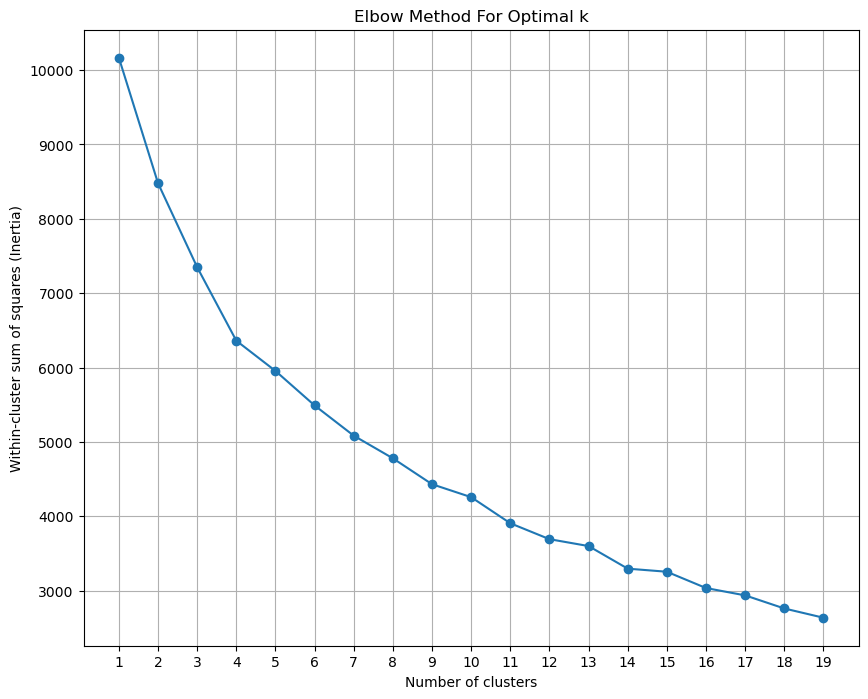

In [73]:
# Calculate the within-cluster sum of squares for different numbers of clusters
inertia = []
for n_clusters in range(1, 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(genre_features_sparse)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(range(1, 20), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares (Inertia)')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

In [74]:
# Re-create the sparse matrix from the original DataFrame
genre_features_sparse = csr_matrix(original_merged_df.loc[:, 'Action':'Western'].values)

# Now run KMeans with the updated number of clusters
kmeans_updated = KMeans(n_clusters=4, random_state=42)
clusters_updated = kmeans_updated.fit_predict(genre_features_sparse)

# Update the cluster labels in the original DataFrame
original_merged_df['cluster'] = clusters_updated


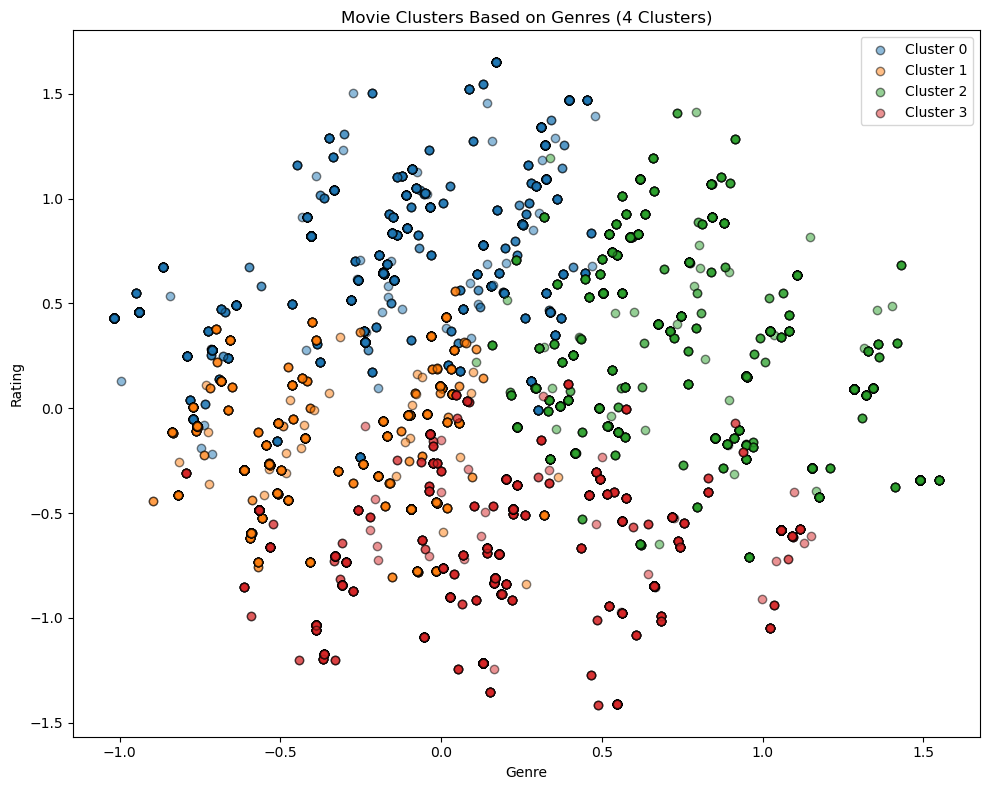

In [87]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(genre_features_sparse.toarray())

# Plot the reduced features colored by their cluster
plt.figure(figsize=(10, 8))

for cluster in np.unique(clusters_updated):
    cluster_indices = np.where(clusters_updated == cluster)[0]
    plt.scatter(reduced_features[cluster_indices, 0], reduced_features[cluster_indices, 1], label=f'Cluster {cluster}', alpha=0.5, edgecolor='k')

plt.xlabel('Genre')
plt.ylabel('Rating')
plt.title('Movie Clusters Based on Genres (4 Clusters)')
plt.legend()
plt.tight_layout()
plt.show()


## Exploring the 4 Movie Clusters 

Centroid values indicate the strength of association in a cluster. High values closer to 1 represent a strong association. 

Cluster 0: Adventure Child Friendly Movies

This cluster is strongly associated with Adventure (0.73) and Children (0.73) movies. The cluster also has strong connections with Fantasy (0.60), Animation (0.58) and Comedy(0.56) genres. 


Cluster 1: Dramatic Movies

This cluster is strongly associated with Drama (0.82). It has a smaller association with Thrillers (0.35), and Crime (0.25)

Cluster 2: Comedy and Romance

This cluster has a very strong association with Comedies (0.99). This cluster also as an association with Romance (0.33), and Drama (0.29).


Cluster 3: Thrilling Action Movies

This Cluster has a strong association with Action (0.92) movies. It also has a strong connection to Adventure (0.52), Sci-Fi (0.52), and Thriller (0.51).


In [76]:
#centroids of the clusters
centroids = kmeans_updated.cluster_centers_

#  genre distribution of the centroids:
centroid_genre_distribution = pd.DataFrame(centroids, columns=genre_features.columns)
print(centroid_genre_distribution)



     Action  Adventure  Animation  Children    Comedy     Crime  Documentary  \
0  0.052326   0.133721   0.156712  0.160148  0.960888  0.101744     0.006342   
1  0.122974   0.071778   0.035503  0.055055  0.000000  0.187291     0.032930   
2  0.726381   0.842297   0.089753  0.087209  0.169331  0.018169     0.000363   
3  0.386691   0.016906   0.002518  0.000360  0.117626  0.548201     0.000000   

      Drama   Fantasy  Film-Noir    Horror      IMAX   Musical   Mystery  \
0  0.311575  0.162791   0.000793  0.027220  0.017178  0.105444  0.012949   
1  0.933625  0.041935   0.011320  0.040906  0.039105  0.032930  0.045536   
2  0.118459  0.250727   0.002544  0.062137  0.092297  0.019985  0.030887   
3  0.437050  0.017626   0.045324  0.121942  0.031295  0.000719  0.293885   

    Romance    Sci-Fi  Thriller       War   Western  
0  0.332452  0.018763  0.014271  0.067389  0.008192  
1  0.199125  0.040134  0.010548  0.171083  0.041420  
2  0.082485  0.495640  0.174782  0.022529  0.033430  
3 

In [77]:

if 'cluster' in original_merged_df.columns and 'rating' in original_merged_df.columns and 'title' in original_merged_df.columns:
    # Find top-rated movies in each cluster
    for cluster_num in range(kmeans_updated.n_clusters):
        # Filter the DataFrame for the current cluster
        top_movies = original_merged_df[original_merged_df['cluster'] == cluster_num]

        # Group by title, calculate the mean rating, and sort the movies by rating
        top_movies = top_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
        
        print(f"Top Movies in Cluster {cluster_num}:\n{top_movies}\n")
else:
    print("One or more required columns are missing in the DataFrame. Please check the DataFrame structure.")




Top Movies in Cluster 0:
title
zoolander 2001                                              5.0
george carlin its bad for ya 2008                           5.0
girl who leapt through time the toki o kakeru shôjo 2006    5.0
girl next door the 2004                                     5.0
ghostbusters ii 1989                                        5.0
ghost world 2001                                            5.0
ghost graduation 2012                                       5.0
ghost 1990                                                  5.0
get smart 2008                                              5.0
get low 2009                                                5.0
Name: rating, dtype: float64

Top Movies in Cluster 1:
title
zulu 1964                                   5.0
gangs of new york 2002                      5.0
gallipoli 1981                              5.0
funny girl 1968                             5.0
full metal jacket 1987                      5.0
front of the class 2008     

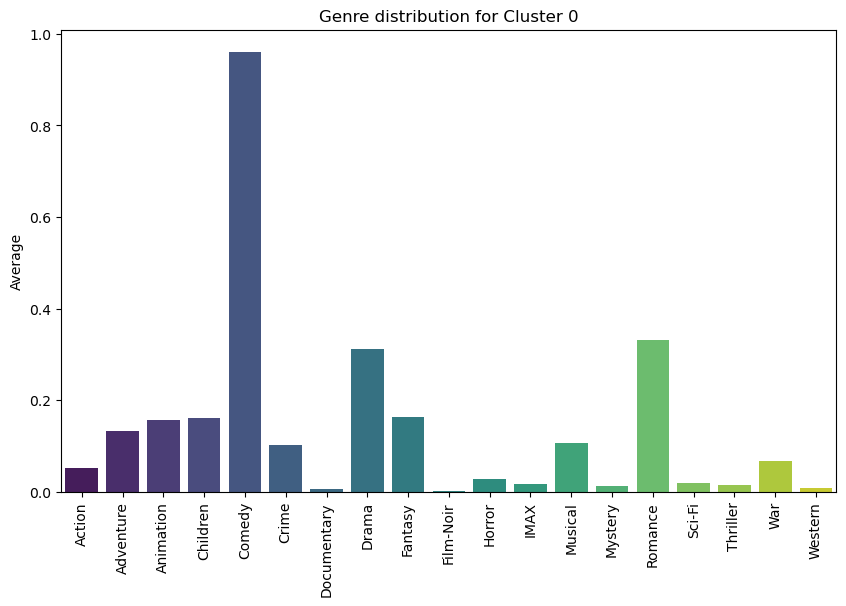

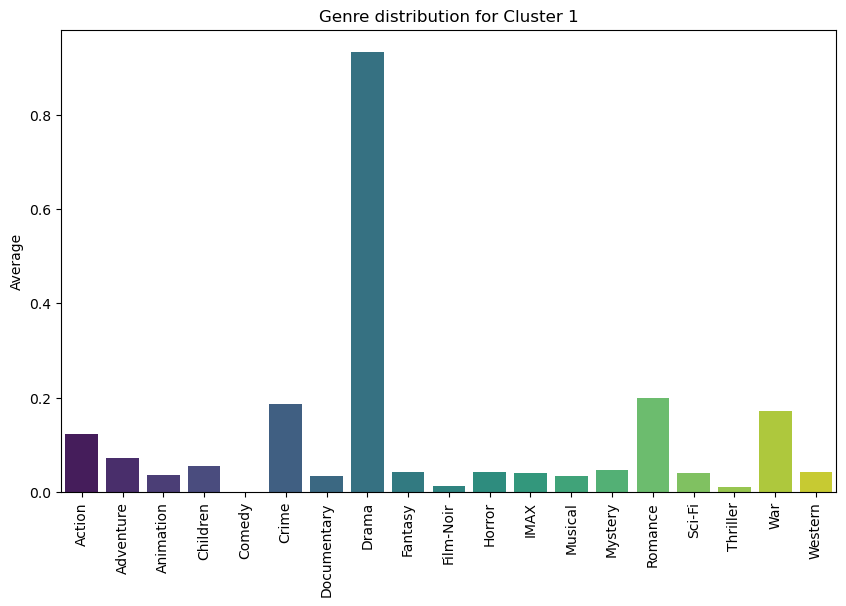

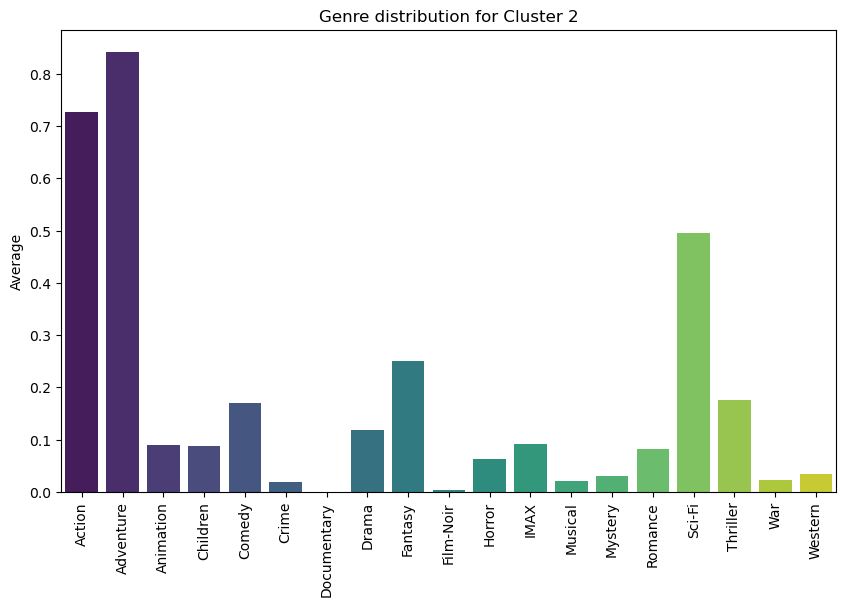

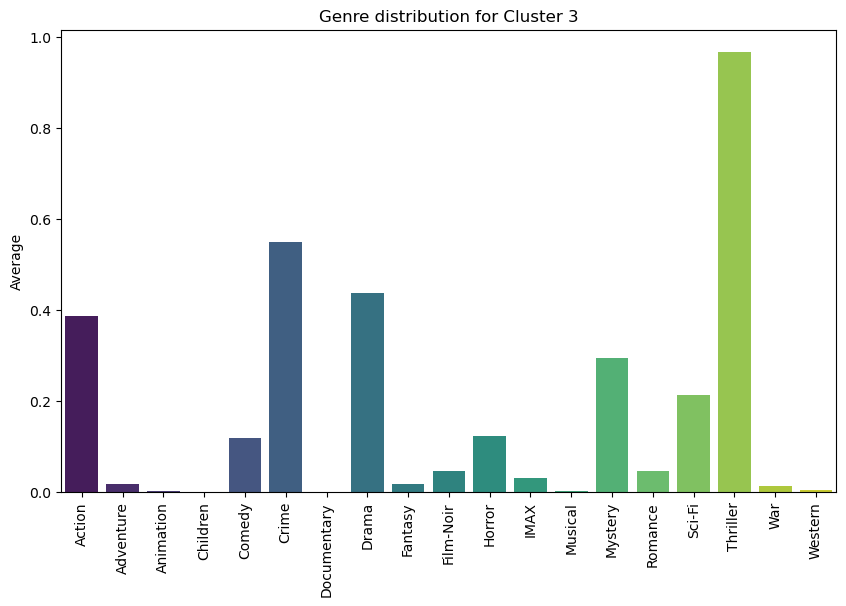

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

for cluster_num in range(kmeans_updated.n_clusters):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=centroid_genre_distribution.columns, y=centroid_genre_distribution.iloc[cluster_num], palette="viridis")
    plt.title(f'Genre distribution for Cluster {cluster_num}')
    plt.xticks(rotation=90)
    plt.ylabel('Average')
    plt.show()


# Conclusions

## Model Evaluation
The streaming service should leverage the SVD Grid Search methodology for making movie recommendations to existing users. This approach has demonstrated the optimal balance between precision and recall, ensuring that the model recommends movies that users are likely to enjoy while avoiding the mistake of suggesting poorly rated movies under the assumption that they would be highly rated. The SVD Grid Search model exhibits higher accuracy compared to the basic SVD model, and most importantly the Grid Search has the best NDCG rating. This rating indicates that the Grid Search model provides the most relevant, and highly-ranked movies for top recommendations. 

To address the cold start problem, the streaming service should also consider K-Means Clustering as a powerful resource. Given that the cold start problem primarily affects new users for whom there is limited or no prior rating information available, K-Means clustering enables movie recommendations on multiple fronts. Each cluster has different types of movies, and genres but are all falling in a similar cluster. The User themselves, can select which cluster they prefer, and then choose a movie of their liking. By clustering movies based on various features, the system can offer initial recommendations to new users based on the characteristics of similar groups of movies. This approach effectively mitigates the cold start problem by providing relevant recommendations even in the absence of explicit user ratings.

Additionally, alongside K-Means clustering, the streaming service could implement a 'Popularity-Based Method' to offer popular movies to new users. By creating a list of the highest-rated movies from the dataset, known as the 'Highest Rated Movies' list, new users can explore and select movies of interest. Also, using this method, the service can easily create subcategories to recommend popular movies by genre. This approach allows users to discover movies across different genres and select the ones that align with their preferences, even without prior knowledge of their favorite genres.

Overall, by integrating both the SVD Grid Search methodology and K-Means clustering along with a Popularity-Based Method, the streaming service can provide comprehensive and tailored movie recommendations to both existing and new users, enhancing the overall user experience.

# Recommendations

To effectively produce movie recommendations that users will enjoy, the streaming service  should use SVD Grid Search modeling. This approach focuses on NDCG, while also analyzing RMSE and MAE as key metrics to fine-tune the recommendation accuracy, which should allow for users to enjoy the movies, and the streaming service.

To address the challenge of recommending movies to new users with no prior viewing history (the cold start problem), it is recommended to implement a 'Popularity-Based Method' initially. This method involves suggesting highly-rated movies to new users, increasing the likelihood that they will enjoy their initial selections. Additionally, implementing movie clustering can further aid in tackling the cold start problem by grouping similar movies together, thereby offering relevant recommendations based on popular or trending movie clusters.  

Once the new user starts watching these movie recommendations, it is important to follow up and adjust the recommendations based on their individual preferences. Switching them from the K-Means or popularity based method, to the Grid search method. 

# Repo Structure
├── gitgnore

├── [README.md](README.md)

├── [movierec notebook](movierecnotebook.ipynb).

└── [movierecslides.pdf](https://github.com/jguzzo522/movierec/blob/main/movierecslides.pdf)